In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ds = xr.open_dataset('your_file.nc')

# Select the variable you want to plot. Replace 'your_variable_name' with the actual variable name.
# Here, we select the first time point and the surface level (assuming level index 0 is surface).
# Adjust indices as needed.
data_to_plot = ds['your_variable_name'].isel(time=0, lev=0)

# Create a figure and an axes with PlateCarree projection
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()  # Add coastlines

# Plot the data
data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(),
                  cbar_kwargs={'shrink': 0.5, 'label': 'your_variable_units'})

# Optionally, set extent to zoom into a specific region
# ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

plt.title('Your Title Here')
plt.show()


In [3]:
print('#### Preparing Training data ####')
train_input_path = '/tng4/users/rdimri/PM2.5-Graphs/sk/train_input_data_183.npy'
train_target_path = '/tng4/users/rdimri/PM2.5-Graphs/sk/train_target_data_183.npy'
train_time_path = '/tng4/users/rdimri/PM2.5-Graphs/sk/train_input_time_183_v3.npy'

train_input = np.load(train_input_path, mmap_mode='r')
train_input_time = np.load(train_time_path, mmap_mode='r')
print(train_input.shape, train_input_time.shape)

#### Preparing Training data ####
(34944, 96, 183, 47) (34944, 96, 183, 2)


In [4]:
# Create a memory-mapped array for the output
shape = (train_input.shape[0], train_input.shape[1], train_input.shape[2], train_input.shape[3] + train_input_time.shape[3])
dtype = train_input.dtype
filename = '/tng4/users/rdimri/PM2.5-Graphs/sk/train_input_combined.npy'
fp = np.memmap(filename, dtype=dtype, mode='w+', shape=shape)

In [5]:
chunk_size = 1000
for i in range(0, len(train_input), chunk_size):
    fp[i:i+chunk_size, :, :, :train_input.shape[3]] = train_input[i:i+chunk_size]
    fp[i:i+chunk_size, :, :, train_input.shape[3]:] = train_input_time[i:i+chunk_size]

In [8]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx])
        label = torch.tensor(self.labels[idx])
        return feature, label

train_target = np.load(train_target_path)
train_dataset = MyDataset(train_input, train_target)

In [4]:
import os 
import sys
import numpy as np
import torch
from collections import OrderedDict
from scipy.spatial import distance
from torch_geometric.utils import dense_to_sparse, to_dense_adj
from geopy.distance import geodesic
from metpy.units import units
import metpy.calc as mpcalc

import pandas as pd
import time
import glob
import xarray as xr

from torch_geometric.nn import ChebConv

import torch
from torch import nn
# from model.cells import GRUCell
from torch.nn import Sequential, Linear, Sigmoid
import numpy as np
from torch_scatter import scatter_add#, scatter_sub  # no scatter sub in lastest PyG
from torch.nn import functional as F
from torch.nn import Parameter
import tqdm as notebook_tqdm
import time

import concurrent.futures
import pandas as pd
import multiprocessing as mp
import threading as th

import time
import pandas as pd
import concurrent.futures as cf
import multiprocessing as mp

import matplotlib.pyplot as plt
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler

In [5]:
nodes = OrderedDict()
folder_path = '/tng4/users/rdimri/korea_srtm/station_wise/'
with open('/tng4/users/rdimri/stations_info_183_lat_lon.csv', 'r') as f:# _201912_distance.csv', 'r') as f:
    for line in f:
        index_long, index_lat, index  = line.rstrip('\n').split(',') #index, longitude, latitude, index_long, index_lat, dist_grid = line.rstrip('\n').split(',')
        index = int(index)
        file_name = 'staion_' + str(index) + '.nc'
        file_path = str(folder_path + file_name)
        
        assert os.path.isfile(file_path)
        latitude = xr.open_dataset(file_path).lat
        longitude = xr.open_dataset(file_path).lon
        longitude, latitude = float(longitude), float(latitude)
        nodes.update({index: {'lon': longitude, 'lat': latitude}})
# list(nodes.items())

In [6]:
start = time.time()
year_str = 2016
year_end = 2021             # up tp 2018
# path_obs =  '/dataFs/dsingh/PM25_grid_forecast/Obs_QA_ext/'  #'/dataFs/dsingh/PM25_grid_forecast/GIST_deliverables/Training_&_Evaluation/Input_data/Obs_ext/'
path_obs =    '/tng4/users/rdimri/Input_data/Obs_ext/'#'/dataFs/dsingh/PM25_grid_forecast/GIST_deliverables/Training_&_Evaluation/Input_data/Obs_ext/'

file_path = []
start = time.time()

num_processes = 4
num_threads = 2
import pandas as pd

new_dates = pd.date_range(start='2022-01-01 00:00:00', end='2022-01-01 12:00:00', freq='H')

for station in range(0, len(list(nodes.items()))):
    for year in range(year_str, year_end + 1):
        path_og = path_obs + str(year) + '/' + str(list(nodes.items())[station][0]) 
        file_path.append(glob.glob(path_og + '*.csv'))
print('Total files are ', len(file_path))


def process_file(filename):
    obs_single = pd.read_csv(filename)       
    obs_single['Unnamed: 0'] = pd.to_datetime(obs_single['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
    obs_single.rename(columns={'Unnamed: 0': 'Date'}, inplace = True)
    if filename[38:42]=='2016':
        obs_single = obs_single.drop(obs_single.index[:13])
        obs_single['station'] = filename[43:49]
        return obs_single
    
    if filename[38:42]=='2021':
        new_data = pd.DataFrame(columns=obs_single.columns)
        new_data['Date'] = pd.DataFrame(new_dates)
        new_data['Station_ID'] = obs_single['Station_ID'][:13]
        obs_single = pd.concat([obs_single, new_data], ignore_index = True)
        obs_single['station'] = filename[43:49]
        return obs_single
    else:
        obs_single['station'] = filename[43:49]
        return obs_single



# Define the function to process a chunk of files in parallel using multithreading
def process_chunk(chunk):
    # Create a pool of worker threads
    with cf.ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Process each file in the chunk using a worker thread
        results = [executor.submit(process_file, filename) for filename in chunk]
        # Wait for all the results to complete
        cf.wait(results)
        # Get the results from the completed futures
        chunk_result = [f.result() for f in results]
        # Concatenate the results into a single dataframe
        chunk_result = pd.concat(chunk_result, ignore_index=True)
    return chunk_result


# def drop_threshold(O):
#     O.SO2[O.SO2>53] = np.nan
#     O.O3[O.O3>0.5] = np.nan
#     O.NO2[O.NO2>0.5] = np.nan
#     O.CO[O.CO>100] = np.nan
#     O.PM10[O.PM10>500] = np.nan
#     O.PM25[O.PM25>500] = np.nan
#     # O[O<0]=np.nan
#     return O

input_files = [str(path[0]) for path in file_path]
num_files_per_chunk = len(file_path) // num_processes
file_chunks = [input_files[i:i+num_files_per_chunk] for i in range(0, len(input_files), num_files_per_chunk)]
    
pool = mp.Pool(num_processes)

results = pool.map(process_chunk, file_chunks)

obs_data = pd.concat(results, ignore_index = True)
# obs_data['Date'] = pd.to_datetime(obs_data['Date'], format='%Y-%m-%d %H:%M:%S')


# obs_data.index = pd.to_datetime(obs_data['Date'])
obs_data = obs_data.drop(['Station_ID'], axis = 1)
# print(obs_data)
obs_data.station = obs_data['station'].astype(int)

# obs_data = drop_threshold(obs_data)

column_rename_dict = {'SO2': 'Obs_SO2', 'O3': 'Obs_O3', 'NO2': 'Obs_NO2', 'PM10' : 'Obs_PM10', 'station' : 'Station_ID'}
obs_data.rename(columns = column_rename_dict, inplace = True)
obs_data.loc[:, obs_data.columns != 'Date'][obs_data.loc[:, obs_data.columns != 'Date'] < 0] = np.nan
# obs_data = obs_data.drop(['Station_ID', 'Date'], axis = 1)
print("Total time it took to compute this cell is ", time.time() - start)

Total files are  1098
Total time it took to compute this cell is  9.397027492523193


/tmp/ipykernel_4076149/1247575812.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_data.loc[:, obs_data.columns != 'Date'][obs_data.loc[:, obs_data.columns != 'Date'] < 0] = np.nan
/tmp/ipykernel_4076149/1247575812.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_data.loc[:, obs_data.columns != 'Date'][obs_data.loc[:, obs_data.columns != 'Date'] < 0] = np.nan


In [4]:
obs_data.shape

(9627264, 8)

In [5]:
obs_data.head(2)

,Date,Obs_SO2,CO,Obs_O3,Obs_NO2,Obs_PM10,PM25,Station_ID
0,2016-01-01 13:00:00,8.0,600.0,8.0,58.0,52.0,28.0,111121
1,2016-01-01 14:00:00,7.0,500.0,8.0,57.0,52.0,28.0,111121


In [5]:
print("Shape of Observation data is ", obs_data.shape)
missing_values = obs_data.isna().sum()
print("Number of missing samples are ", missing_values)
print("Percentage of missing samples are ", (missing_values/len(obs_data))*100)
print("Columns are ", obs_data.columns)

Shape of Observation data is  (1315200, 8)
Number of missing samples are  Date              0
Obs_SO2       30615
CO            37437
Obs_O3        29759
Obs_NO2       29928
Obs_PM10      40455
PM25          36295
Station_ID        0
dtype: int64
Percentage of missing samples are  Date          0.000000
Obs_SO2       2.327783
CO            2.846487
Obs_O3        2.262698
Obs_NO2       2.275547
Obs_PM10      3.075958
PM25          2.759656
Station_ID    0.000000
dtype: float64
Columns are  Index(['Date', 'Obs_SO2', 'CO', 'Obs_O3', 'Obs_NO2', 'Obs_PM10', 'PM25',
       'Station_ID'],
      dtype='object')


In [6]:
len(obs_data)

1315200

In [4]:
import time
start = time.time()
# Path = "/dataFs/dsingh/PM25_grid_forecast/GIST_deliverables/Training_&_Evaluation/"
path_mcip = '/tng4/users/rdimri/Input_data/MCIP_ext/'
# station_ID = pd.read_csv('/dataFs/dsingh/PM25_grid_forecast/GIST_deliverables/Training_&_Evaluation/Misc/korea_urban_site_201912_distance.csv', header = None)
station_ID = pd.read_csv('/tng4/users/rdimri/stations_info_183_lat_lon.csv', header = None)
# station_ID1 = pd.read_csv('/tng4/users/rdimri/old_home/korea_urban_site.csv', header = None)
file_path = []
for i in range(0, len(nodes.items())):
    for year in range(year_str, year_end + 1):
        if (list(nodes.items())[i][0] == int(station_ID[2][i])):
            path_og = path_mcip + str(year) + '/'
            file_path.append(path_og + str(station_ID[0][i]) + '_' + str(station_ID[1][i]) + '.csv')
print('Total files are ', len(file_path))
mcip_data_chunk = []

def process_file(filename):
    mcip_single = pd.read_csv(filename)
    mcip_single.rename(columns={'Date Local': 'Date'}, inplace = True)
    mcip_single['Date'] = pd.to_datetime(mcip_single['Date'])
    mcip_single = mcip_single.set_index('Date').asfreq('1H')
    return mcip_single


def process_chunk(chunk):
    # Create a pool of worker threads
    with cf.ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Process each file in the chunk using a worker thread
        results = [executor.submit(process_file, filename) for filename in chunk]
        # Wait for all the results to complete
        cf.wait(results)
        # Get the results from the completed futures
        chunk_result = [f.result() for f in results]
        # Concatenate the results into a single dataframe
        chunk_result = pd.concat(chunk_result, ignore_index=True)
    return chunk_result


input_files = [str(path) for path in file_path]
num_files_per_chunk = len(file_path) // num_processes
file_chunks = [input_files[i:i+num_files_per_chunk] for i in range(0, len(input_files), num_files_per_chunk)]
    

pool = mp.Pool(num_processes)


results = pool.map(process_chunk, file_chunks)

 
mcip_data = pd.concat(results, ignore_index = True)
mcip_data.rename(columns={'Date UTC': 'Date'}, inplace = True)
mcip_data = mcip_data.drop('Date', axis = 1)
print("Total time it took to compute this cell is ", time.time() - start)

Total files are  1098


Total time it took to compute this cell is  19.54856848716736


In [5]:
print(mcip_data.shape)
print(mcip_data.columns)

(9627264, 31)
Index(['PRSFC', 'USTAR', 'WSTAR', 'PBL', 'MOLI', 'HFX', 'RADYNI', 'RSTOMI',
       'TEMPG', 'TEMP2', 'Q2', 'WSPD10', 'WDIR10', 'GLW', 'GSW', 'RGRND', 'RN',
       'RC', 'CFRAC', 'CLDT', 'CLDB', 'WBAR', 'SNOCOV', 'VEG', 'LAI', 'WR',
       'SOIM1', 'SOIM2', 'SOIT1', 'SOIT2', 'SLTYP'],
      dtype='object')


In [8]:
data = pd.read_csv('/tng4/users/rdimri/Input_data/MCIP_ext/2021/44_89.csv')
data['Date UTC'] = pd.to_datetime(data['Date UTC'])
data = data.set_index('Date UTC').asfreq('1H')
data.head(2)

,Date Local,PRSFC,USTAR,WSTAR,PBL,MOLI,HFX,RADYNI,RSTOMI,TEMPG,...,WBAR,SNOCOV,VEG,LAI,WR,SOIM1,SOIM2,SOIT1,SOIT2,SLTYP
Date UTC,,,,,,,,,,,,,,,,,,,,,
2021-01-01 04:00:00,2021-01-01 13:00:00,101810.726562,0.248800,1.534514,1217.582764,-0.077076,123.165001,0.010291,0.0,289.082458,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,273.160004,273.160004,14.0
2021-01-01 05:00:00,2021-01-01 14:00:00,101779.046875,0.254996,1.562380,1307.784424,-0.070354,121.490623,0.010478,0.0,289.082458,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,273.160004,273.160004,14.0


In [113]:
missing_values = mcip_data.isnull().any(axis=1)
len(missing_values)

8760

In [116]:
mcip_data = data.copy()
mcip_data['Date UTC'] = pd.to_datetime(mcip_data['Date UTC'])  # Add this line to create the 'Date' column
# mask = mcip_data['Date UTC'].dt.year == 2021
missing_values = mcip_data.isnull().any(axis=1)
missing_dates = mcip_data[missing_values]['Date UTC']

print("Dates in 2021 with missing data:", missing_dates)

KeyError: 'Date UTC'

In [34]:
mcip_data['Date'] = pd.to_datetime(mcip_data['Date'])
mask = (mcip_data['Date'].dt.year == 2021)
mcip_data_dec_2021 = mcip_data[mask]
for column in mcip_data_dec_2021.columns:
    missing_values = mcip_data_dec_2021[column].isna()
    missing_dates = mcip_data_dec_2021[missing_values]['Date'].unique()
    print(f"Missing dates in December 2021 for column '{column}':")
    for date in missing_dates:
        print(date)

Missing dates in December 2021 for column 'Date':
Missing dates in December 2021 for column 'PRSFC':
Missing dates in December 2021 for column 'USTAR':
Missing dates in December 2021 for column 'WSTAR':
Missing dates in December 2021 for column 'PBL':
Missing dates in December 2021 for column 'MOLI':
Missing dates in December 2021 for column 'HFX':
Missing dates in December 2021 for column 'RADYNI':
Missing dates in December 2021 for column 'RSTOMI':
Missing dates in December 2021 for column 'TEMPG':
Missing dates in December 2021 for column 'TEMP2':
Missing dates in December 2021 for column 'Q2':
Missing dates in December 2021 for column 'WSPD10':
Missing dates in December 2021 for column 'WDIR10':
Missing dates in December 2021 for column 'GLW':
Missing dates in December 2021 for column 'GSW':
Missing dates in December 2021 for column 'RGRND':
Missing dates in December 2021 for column 'RN':
Missing dates in December 2021 for column 'RC':
Missing dates in December 2021 for column 'CFR

In [9]:
mcip_data.shape, obs_data.shape

((9627264, 31), (9627264, 8))

In [25]:
import time
start = time.time()

path_cmaq = '/tng4/users/rdimri/Input_data/CMAQ_ext/'
# station_ID = pd.read_csv('/dataFs/dsingh/PM25_grid_forecast/GIST_deliverables/Training_&_Evaluation/Misc/korea_urban_site_201912_distance.csv', header = None)
station_ID = pd.read_csv('/tng4/users/rdimri/stations_info_183_lat_lon.csv', header = None)
file_path = []
for i in range(0, len(nodes.items())):
    for year in range(year_str, year_end + 1):
        if (list(nodes.items())[i][0] == station_ID[2][i]):
            path_og = path_cmaq + str(year) + '/'
            # print(path_og)
            file_path.append(path_og + str(station_ID[0][i]) + '_' + str(station_ID[1][i]) + '.csv')
print('Total files are ', len(file_path)) 
 
cmaq_data_chunk = []

def process_file(filename):
    cmaq_single = pd.read_csv(filename)
    cmaq_single.rename(columns={'Date Local': 'Date'}, inplace = True)
    cmaq_single['Date'] = pd.to_datetime(cmaq_single['Date'])
    
    # cmaq_single['Data1'] = pd.to_datetime(cmaq_single['Date'])
    cmaq_single = cmaq_single.set_index('Date').asfreq('1H')
    return cmaq_single



# Define the function to process a chunk of files in parallel using multithreading
def process_chunk(chunk):
    # Create a pool of worker threads
    with cf.ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Process each file in the chunk using a worker thread
        results = [executor.submit(process_file, filename) for filename in chunk]
        # Wait for all the results to complete
        cf.wait(results)
        # Get the results from the completed futures
        chunk_result = [f.result() for f in results]
        # Concatenate the results into a single dataframe
        chunk_result = pd.concat(chunk_result, ignore_index=True)
    return chunk_result

# Split the input files into multiple chunks
input_files = [str(path) for path in file_path]
num_files_per_chunk = len(file_path) // num_processes
file_chunks = [input_files[i:i+num_files_per_chunk] for i in range(0, len(input_files), num_files_per_chunk)]
    
# Create a pool of worker processes
pool = mp.Pool(num_processes)

# Process each chunk of files in parallel using a worker process
results = pool.map(process_chunk, file_chunks)
# print(results.head(10))
cmaq_data = pd.concat(results, ignore_index = True)
# cmaq_data.rename(columns={'Date1': 'Date'}, inplace = True)
cmaq_data = cmaq_data.drop(['Date UTC', 'SO2'], axis = 1)
print("Total time it took to compute this cell is ", time.time() - start)

Total files are  1098


Total time it took to compute this cell is  8.974395990371704


In [26]:
file_path

['/tng4/users/rdimri/Input_data/CMAQ_ext/2016/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2017/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2018/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2019/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2020/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2021/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2016/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2017/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2018/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2019/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2020/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2021/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2016/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2017/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2018/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2019/62_90.csv',
 '/tng4/users/rdimri/Input_data/CMAQ_ext/2020/62_90.csv',
 '/tng4/users/

In [5]:
cmaq_data.columns

Index(['PM10', 'PM2P5', 'O3', 'NOX', 'NO', 'NO2', 'ISOPRENE', 'OLES', 'AROS',
       'ALKS'],
      dtype='object')

In [ ]:
def process_file(filename):
    cmaq_single = pd.read_csv(filename)
    cmaq_single.rename(columns={'Date Local': 'Date'}, inplace = True)
    cmaq_single['Date'] = pd.to_datetime(cmaq_single['Date'])
    
    # cmaq_single['Data1'] = pd.to_datetime(cmaq_single['Date'])
    cmaq_single = cmaq_single.set_index('Date').asfreq('1H')
    return cmaq_single


In [71]:
obs_data.head(2)

,Date,Obs_SO2,CO,Obs_O3,Obs_NO2,Obs_PM10,PM25,Station_ID
0,2016-01-01 13:00:00,8.0,600.0,8.0,58.0,52.0,28.0,111121
1,2016-01-01 14:00:00,7.0,500.0,8.0,57.0,52.0,28.0,111121


In [68]:
data = pd.read_csv('/tng4/users/rdimri/Input_data/MCIP_ext/2021/44_89.csv')
data.rename(columns={'Date Local': 'Date'}, inplace = True)
data['Date'] = pd.to_datetime(data['Date'])
# data = data.set_index('Date').asfreq('1H')  
len(data)

8712

In [71]:
mask = mcip_data['Date UTC'].dt.year == 2021
missing_values = data[mask].isnull().any(axis=1)
missing_dates = data[mask][missing_values]['Date'].dt.date.unique()
print(len(missing_dates))
print("Dates in 2021 with missing data:", missing_dates)

KeyError: 'Date UTC'

In [12]:
cmaq_data.columns, mcip_data.columns, obs_data.columns

(Index(['PM10', 'PM2P5', 'O3', 'NOX', 'NO', 'NO2', 'ISOPRENE', 'OLES', 'AROS',
        'ALKS'],
       dtype='object'),
 Index(['PRSFC', 'USTAR', 'WSTAR', 'PBL', 'MOLI', 'HFX', 'RADYNI', 'RSTOMI',
        'TEMPG', 'TEMP2', 'Q2', 'WSPD10', 'WDIR10', 'GLW', 'GSW', 'RGRND', 'RN',
        'RC', 'CFRAC', 'CLDT', 'CLDB', 'WBAR', 'SNOCOV', 'VEG', 'LAI', 'WR',
        'SOIM1', 'SOIM2', 'SOIT1', 'SOIT2', 'SLTYP'],
       dtype='object'),
 Index(['Date', 'Obs_SO2', 'CO', 'Obs_O3', 'Obs_NO2', 'Obs_PM10', 'PM25',
        'Station_ID'],
       dtype='object'))

In [13]:
cmaq_data.shape, mcip_data.shape, obs_data.shape

((1315200, 10), (1315200, 31), (1315200, 8))

In [10]:
# print(mcip_data.columns, '\n', obs_data.columns)
start = time.time()
# mcip_data['Date'] = pd.to_datetime(mcip_data['Date'])
df_concatenated = pd.concat([mcip_data, cmaq_data, obs_data], axis = 1)
df_concatenated = df_concatenated[~((df_concatenated.Date.dt.month==2) & (df_concatenated.Date.dt.day==29))]
print(len(df_concatenated.columns))
print(df_concatenated.columns)
print("Concatenate time is ", time.time() - start)

49
Index(['PRSFC', 'USTAR', 'WSTAR', 'PBL', 'MOLI', 'HFX', 'RADYNI', 'RSTOMI',
       'TEMPG', 'TEMP2', 'Q2', 'WSPD10', 'WDIR10', 'GLW', 'GSW', 'RGRND', 'RN',
       'RC', 'CFRAC', 'CLDT', 'CLDB', 'WBAR', 'SNOCOV', 'VEG', 'LAI', 'WR',
       'SOIM1', 'SOIM2', 'SOIT1', 'SOIT2', 'SLTYP', 'PM10', 'PM2P5', 'O3',
       'NOX', 'NO', 'NO2', 'ISOPRENE', 'OLES', 'AROS', 'ALKS', 'Date',
       'Obs_SO2', 'CO', 'Obs_O3', 'Obs_NO2', 'Obs_PM10', 'PM25', 'Station_ID'],
      dtype='object')
Concatenate time is  4.00337815284729


In [7]:
from sklearn.preprocessing import StandardScaler
df_concatenated.columns

NameError: name 'df_concatenated' is not defined

Text(0.5, 1.0, 'Example Plot with Bigger Labels')

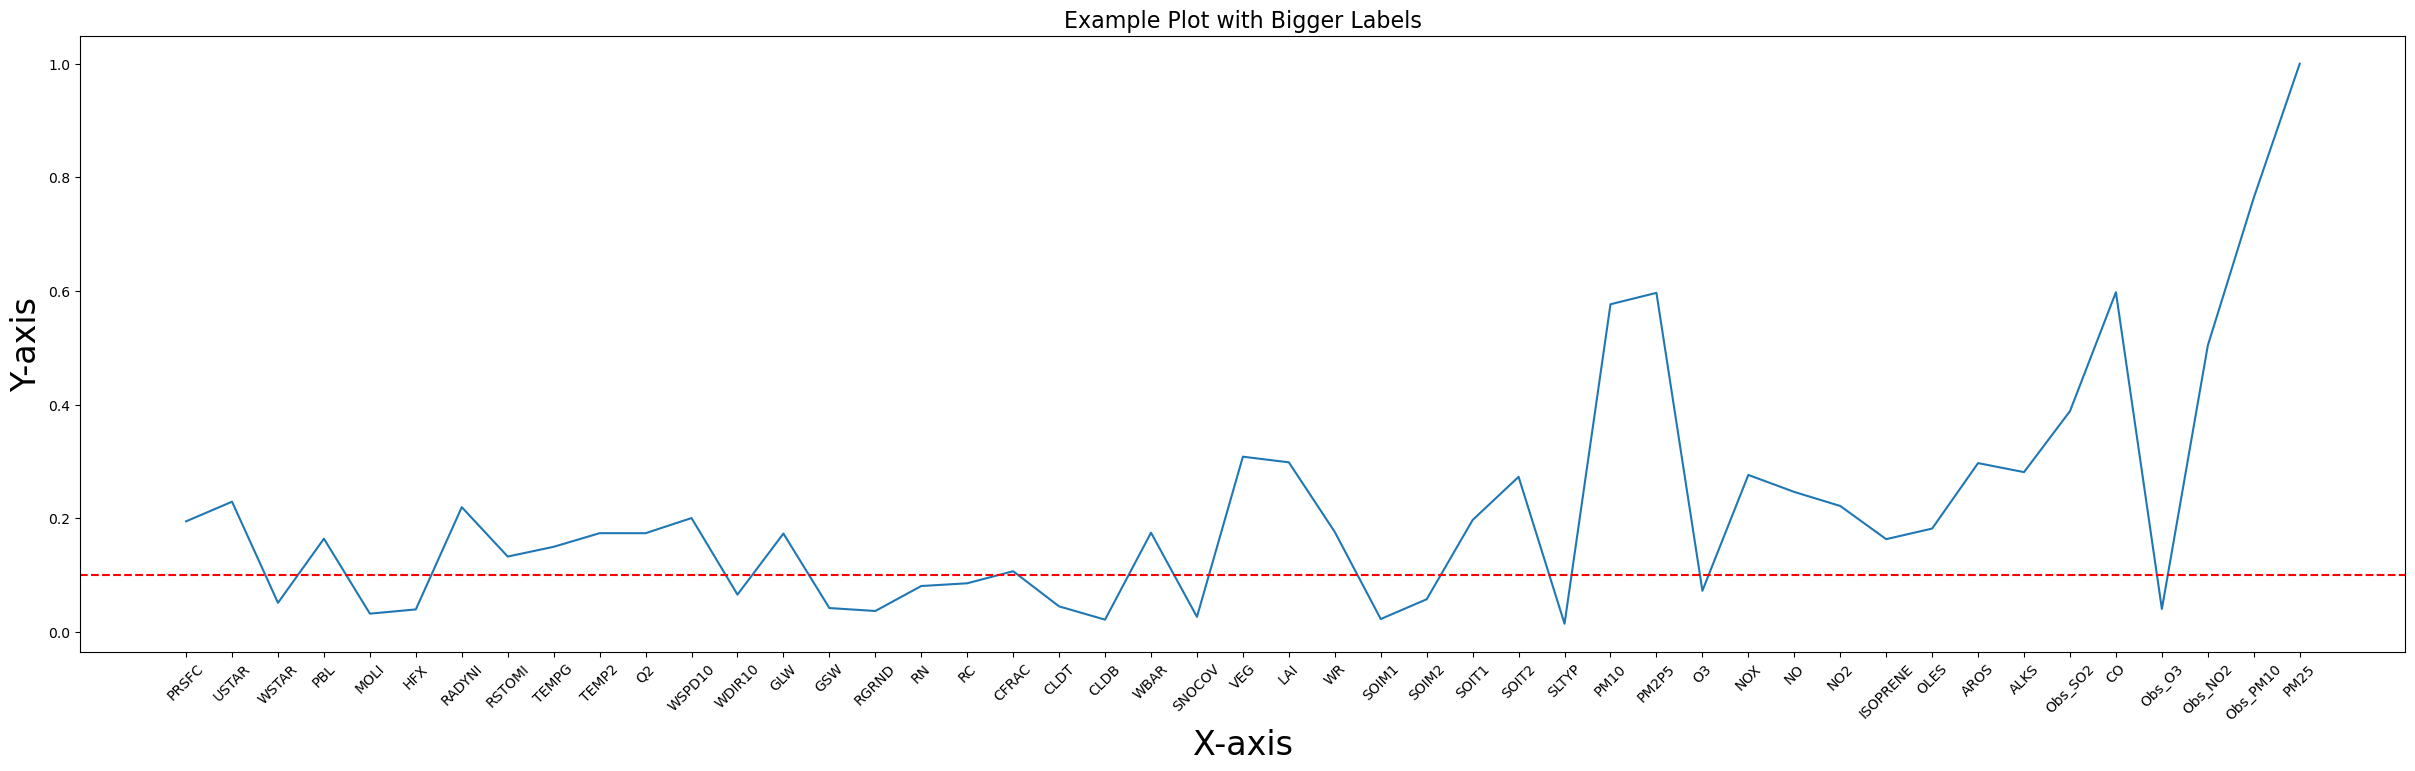

In [86]:
correlation_matrix = df_concatenated[:8760*25].corr()


fig, axs = plt.subplots(figsize=(30, 8))
plt.plot(np.abs(correlation_matrix['PM25']))
horizontal_line_y = 0.1
plt.xticks(rotation = 45)
plt.axhline(y = horizontal_line_y, color = 'red', linestyle = '--', label = 'Horizontal Line')
plt.xlabel('X-axis', fontsize = 24)  # Increase the font size for x-axis label
plt.ylabel('Y-axis', fontsize = 24)  # Increase the font size for y-axis label
plt.title('Example Plot with Bigger Labels', fontsize=16)  # Increase the font size for title



In [18]:
df_mean_std = pd.DataFrame()
df_mean_std['Mean'] = df_mean
df_mean_std['STD'] = df_std
df_mean_std.to_csv('/tng4/users/rdimri/Pearson_graph_conv1d/seoul/mean_std_405.csv')

In [13]:
wind_data = df_concatenated.loc[:,['WSPD10', 'WDIR10']]

In [16]:
wind_data.shape

(1314000, 2)

In [17]:
wind_data[:24]

,WSPD10,WDIR10
0,2.671034,233.871796
1,3.269802,235.610016
2,3.692011,235.303345
3,3.325839,231.927109
4,2.822086,225.841888
5,2.574584,218.046204
6,2.376900,209.761353
7,2.318222,202.321045
8,2.360944,195.926880
9,2.877523,194.759491


In [8]:
pm_ts = df_concatenated[['PM25', 'Date']]

In [9]:
pm_ts

,PM25,Date
0,28.0,2016-01-01 13:00:00
1,28.0,2016-01-01 14:00:00
2,18.0,2016-01-01 15:00:00
3,17.0,2016-01-01 16:00:00
4,17.0,2016-01-01 17:00:00
...,...,...
9627259,NaN,2022-01-01 08:00:00
9627260,NaN,2022-01-01 09:00:00
9627261,NaN,2022-01-01 10:00:00
9627262,NaN,2022-01-01 11:00:00


/tmp/ipykernel_3833154/3046086017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_ts['Month'] = pm_ts['Date'].dt.month


Text(0.5, 1.0, 'cos transformation: np.cos(30 * (months - 3))')

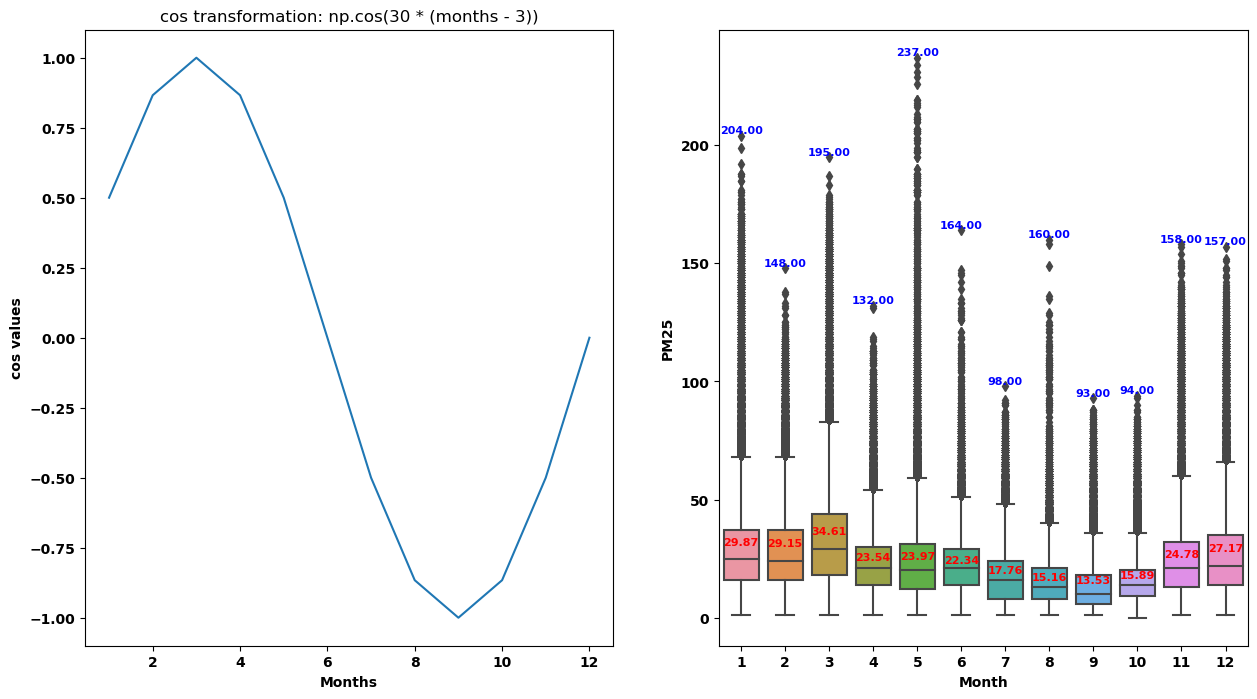

In [76]:
pm_ts = df_concatenated[['PM25', 'Date']]
pm_ts['Month'] = pm_ts['Date'].dt.month
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, axs = plt.subplots(1, 2, figsize=(15, 8))# plt.figure(figsize=(12, 6))
axs[0].plot(range(1,13), np.cos(np.deg2rad(30) * (np.arange(1, 13) - 3)))
axs[0].set(xlabel='Months', ylabel='cos values')
axs[1] = sns.boxplot(x='Month', y='PM25', data = pm_ts, showfliers=True)
def max_outlier(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    max_outlier = (series > (Q3 + 1.5 * IQR)).max()
    return series[series > (Q3 + 1.5 * IQR)].max() if max_outlier else None

mean_values = pm_ts.groupby('Month')['PM25'].mean()
max_outlier_values = pm_ts.groupby('Month')['PM25'].agg(max_outlier)

for i, (mean_val, max_outlier_val) in enumerate(zip(mean_values, max_outlier_values)):
    axs[1].text(i, mean_val, f'{mean_val:.2f}', ha='center', va='bottom', color='red', fontsize=8, fontweight = 'bold')
    if not pd.isnull(max_outlier_val):
        # Find the x-coordinate of the maximum outlier value
        x_coord = i + 1 if axs[1].get_xticks()[1] - axs[1].get_xticks()[0] > 1 else i  # Adjust for narrow boxes
        axs[1].text(x_coord, max_outlier_val, f'{max_outlier_val:.2f}', ha='center', va='bottom', color='blue', fontsize=8, fontweight = 'bold')

axs[0].set_title('cos transformation: np.cos(30 * (months - 3))')
# plt.savefig('/tng4/users/rdimri/Pearson_graph_conv1d/month_cos_transformation.png', dpi = 300, bbox_inches = 'tight')

/tmp/ipykernel_3833154/192931687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_ts['Hour'] = pm_ts['Date'].dt.hour


Text(0, 0.5, 'cos values')

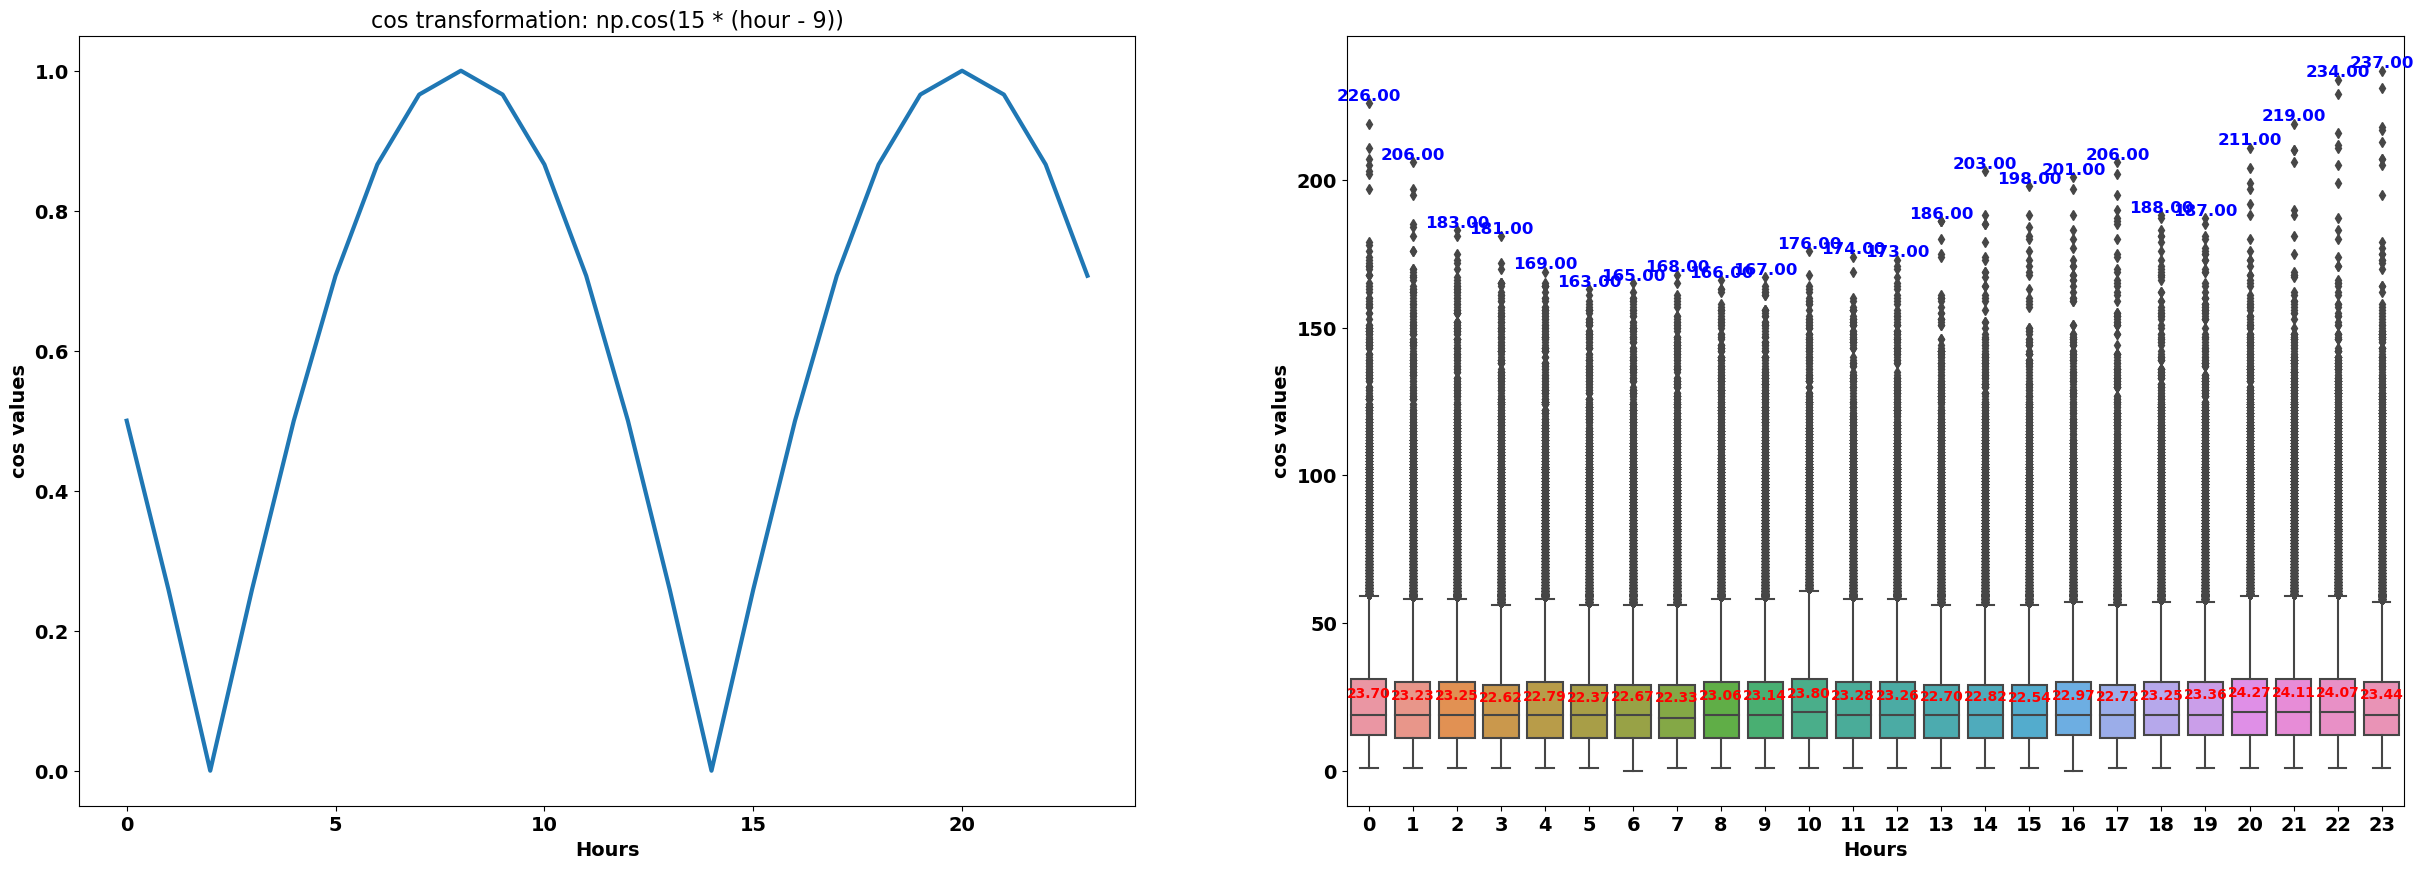

In [80]:
pm_ts = df_concatenated[['PM25', 'Date']]
pm_ts['Hour'] = pm_ts['Date'].dt.hour

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, axs = plt.subplots(1, 2, figsize=(30, 10))# plt.figure(figsize=(12, 6))
axs[0].plot(range(0,24), np.abs(np.cos(np.deg2rad(15) * (np.arange(1, 25) - 9))), linewidth = 3)
axs[0].set_xlabel('Hours', size=14)
axs[0].set_ylabel('cos values', size=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)  # Set tick label size

axs[1] = sns.boxplot(x='Hour', y='PM25', data = pm_ts, showfliers=True)
axs[1].tick_params(axis='both', which='major', labelsize=14)
def max_outlier(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    max_outlier = (series > (Q3 + 1.5 * IQR)).max()
    return series[series > (Q3 + 1.5 * IQR)].max() if max_outlier else None

mean_values = pm_ts.groupby('Hour')['PM25'].mean()
max_outlier_values = pm_ts.groupby('Hour')['PM25'].agg(max_outlier)

for i, (mean_val, max_outlier_val) in enumerate(zip(mean_values, max_outlier_values)):
    axs[1].text(i, mean_val, f'{mean_val:.2f}', ha='center', va='bottom', color='red', fontsize=10, fontweight = 'bold')
    if not pd.isnull(max_outlier_val):
        # Find the x-coordinate of the maximum outlier value
        x_coord = i + 1 if axs[1].get_xticks()[1] - axs[1].get_xticks()[0] > 1 else i  # Adjust for narrow boxes
        axs[1].text(x_coord, max_outlier_val, f'{max_outlier_val:.2f}', ha='center', va='bottom', color='blue', fontsize=12, fontweight = 'bold')

axs[0].set_title('cos transformation: np.cos(15 * (hour - 9))', size = 16)
axs[1].set_xlabel('Hours', size=14)
axs[1].set_ylabel('cos values', size=14)
# plt.savefig('/tng4/users/rdimri/Pearson_graph_conv1d/hour_cos_transformation.png', dpi = 300, bbox_inches = 'tight')

In [14]:
monthly_mean_over_years = monthly_mean.groupby(monthly_mean.index.month).mean()
hourly_mean_over_years = hourly_mean.groupby(hourly_mean.index.hour).mean()

In [24]:
pm_ts

,PM25,Date
0,28.0,2016-01-01 13:00:00
1,28.0,2016-01-01 14:00:00
2,18.0,2016-01-01 15:00:00
3,17.0,2016-01-01 16:00:00
4,17.0,2016-01-01 17:00:00
...,...,...
1315195,NaN,2022-01-01 08:00:00
1315196,NaN,2022-01-01 09:00:00
1315197,NaN,2022-01-01 10:00:00
1315198,NaN,2022-01-01 11:00:00


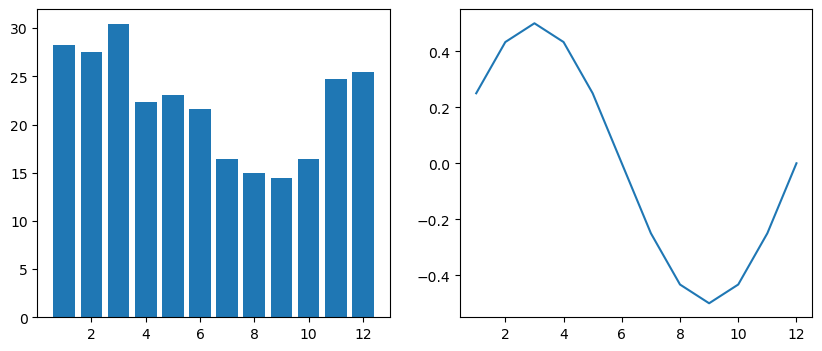

In [220]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.bar(range(1,13), monthly_mean_over_years['PM25'])
# ax1.ylim((10, 31))
ax2.plot(range(1,13), 0.5*np.cos(np.deg2rad(30) * (np.arange(1, 13) - 3)))

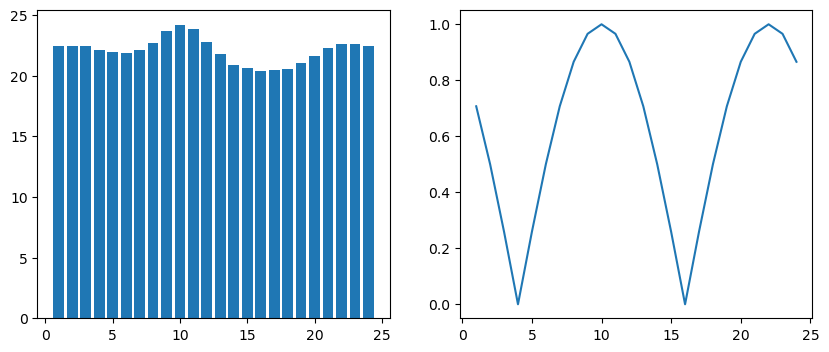

In [217]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.bar(range(1,25), hourly_mean_over_years['PM25'])
# plt.ylim((20, 25))
hour_cos = np.abs(np.cos(np.deg2rad(15) * (np.arange(1, 25) - 10)))
ax2.plot(range(1,25), hour_cos)

In [25]:
len(df_concatenated.columns)

49

In [9]:
df = df_concatenated.copy()
dates = df_concatenated.Date.values  
# stations = df_concatenated.Station_ID.values  
cols = ['Date', 'Station_ID']
df = df.drop(cols, axis = 1)

NameError: name 'df_concatenated' is not defined

In [155]:
df.columns[keep_indices]

Index(['PRSFC', 'USTAR', 'WSTAR', 'PBL', 'MOLI', 'RSTOMI', 'TEMPG', 'Q2',
       'WSPD10', 'WDIR10', 'GSW', 'RN', 'RC', 'CFRAC', 'CLDB', 'WBAR',
       'SNOCOV', 'VEG', 'LAI', 'WR', 'SOIM1', 'SOIT2', 'SLTYP', 'PM2P5', 'O3',
       'NO', 'NO2', 'ISOPRENE', 'OLES', 'AROS', 'Obs_SO2', 'CO', 'Obs_O3',
       'Obs_NO2', 'Obs_PM10', 'PM25'],
      dtype='object')

In [156]:
cmaq_data.columns

Index(['PM10', 'PM2P5', 'O3', 'NOX', 'NO', 'NO2', 'ISOPRENE', 'OLES', 'AROS',
       'ALKS'],
      dtype='object')

In [151]:
tt = df
all_indices = list(range(47))
remove_indices = [5, 6, 9, 13, 15, 19, 27, 28, 31, 34, 40]
keep_indices = [i for i in all_indices if i not in remove_indices]
tt[:, keep_indices].shape

InvalidIndexError: (slice(None, None, None), [0, 1, 2, 3, 4, 7, 8, 10, 11, 12, 14, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 29, 30, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46])

In [149]:
tt

array([[1.01660375e+05, 2.34754235e-01, 1.03363323e+00, ...,
        5.80000000e+01, 5.20000000e+01, 2.80000000e+01],
       [1.01604820e+05, 2.62134433e-01, 9.54338789e-01, ...,
        5.70000000e+01, 5.20000000e+01, 2.80000000e+01],
       [1.01550445e+05, 2.67919183e-01, 7.35821426e-01, ...,
        4.20000000e+01, 4.00000000e+01, 1.80000000e+01],
       ...,
       [1.00646578e+05, 4.82990503e-01, 7.93830216e-01, ...,
                   nan,            nan,            nan],
       [1.00641297e+05, 4.54654455e-01, 9.74669158e-01, ...,
                   nan,            nan,            nan],
       [1.00554320e+05, 4.31343198e-01, 1.18091810e+00, ...,
                   nan,            nan,            nan]])

In [21]:
validation_indices = np.logical_and(dates >= np.datetime64('2020-01-01 13:00:00'), pd.to_datetime(dates) < np.datetime64('2021-01-01 13:00:00'))
test = df.values[validation_indices, :]
test.shape

(1603080, 47)

In [13]:
def add_t(arr, seq_len):
    t_len = arr.shape[0]
    assert t_len > seq_len
    arr_ts = []
    for i in range(seq_len, t_len):
        arr_t = arr[i-seq_len:i]
        arr_ts.append(arr_t)
    arr_ts = np.stack(arr_ts, axis=0)
    return arr_ts


# Reshape the array into the desired shape
def reshaping(x, pm):
    
    # preparing the input features in the format (number_of_days/batch_size/number_of_samples, number_of_stations, number_of features)
    # Get the number of days, number of stations, and number of features
    
    num_stations = 183
    num_days = int(len(x) / (num_stations))
    if pm:
        num_features = 1
    else:
        num_features = 2
    
    reshaped_array = x.reshape(num_days, num_stations, num_features, order = 'F')
    reshaped_array = add_t(reshaped_array, 24 + 72)
    
    ###########################################################################################################################
    
    return reshaped_array

# test_dates = dates >= np.datetime64('2021-01-01 13:00:00')
dates = df_concatenated['Date']
validation_indices = dates >= np.datetime64('2021-01-01 13:00:00')#np.logical_and(dates >= np.datetime64('2020-01-01 13:00:00'), pd.to_datetime(dates) < np.datetime64('2021-01-01 13:00:00'))
val_dates = dates[validation_indices]
print(val_dates.shape)
val_dates = np.array(val_dates)[:, np.newaxis]
print(val_dates.shape)
test_dates = reshaping(val_dates, True)
print(test_dates.shape)

(1603080,)
(1603080, 1)
(8664, 96, 183, 1)


In [15]:
test_dates = test_dates[:, 24:, :]

In [17]:
test_dates[:,0,0,0]

array(['2021-01-02T13:00:00.000000000', '2021-01-02T14:00:00.000000000',
       '2021-01-02T15:00:00.000000000', ...,
       '2021-12-29T10:00:00.000000000', '2021-12-29T11:00:00.000000000',
       '2021-12-29T12:00:00.000000000'], dtype='datetime64[ns]')

In [18]:
test_dates[:,71,0,0]

array(['2021-01-05T12:00:00.000000000', '2021-01-05T13:00:00.000000000',
       '2021-01-05T14:00:00.000000000', ...,
       '2022-01-01T09:00:00.000000000', '2022-01-01T10:00:00.000000000',
       '2022-01-01T11:00:00.000000000'], dtype='datetime64[ns]')

In [31]:
# Imputation of data, filling missing values
def add_t(arr, seq_len):
    t_len = arr.shape[0]
    assert t_len > seq_len
    arr_ts = []
    for i in range(seq_len, t_len):
        arr_t = arr[i-seq_len:i]
        arr_ts.append(arr_t)
    arr_ts = np.stack(arr_ts, axis=0)
    return arr_ts


# Reshape the array into the desired shape
def reshaping(x, pm):
    
    # preparing the input features in the format (number_of_days/batch_size/number_of_samples, number_of_stations, number_of features)
    # Get the number of days, number of stations, and number of features
    
    num_stations = 183
    num_days = int(len(x) / (num_stations))
    if pm:
        num_features = 1
    else:
        num_features = 2
    
    reshaped_array = x.reshape(num_days, num_stations, num_features, order = 'F')
    reshaped_array = add_t(reshaped_array, 24 + 72)
    
    ###########################################################################################################################
    
    return reshaped_array


def train_val_test_split(x, flag):
    
    dates = np.array(pd.to_datetime(df_concatenated['Date']), dtype = 'datetime64')
    train_indices = np.logical_and(dates >= np.datetime64('2016-01-01 13:00:00'), pd.to_datetime(dates) < np.datetime64('2020-01-01 13:00:00'))
    validation_indices = np.logical_and(dates >= np.datetime64('2020-01-01 13:00:00'), pd.to_datetime(dates) < np.datetime64('2021-01-01 13:00:00'))
    test_indices = dates >= np.datetime64('2021-01-01 13:00:00')
    
    
    if flag == 'Train':
        feature = x[train_indices, :]
        print(f"Shape of Training feature set is {feature.shape}")
    if flag == 'Val':
        feature = x[validation_indices, :] 
        print(f"Shape of Validation feature set is {feature.shape}")
    if flag == 'Test':
        feature = x[test_indices, :] 
        print(f"Shape of Testing feature set is {feature.shape}")
        
    return feature

def data_collection(x, flag):
    x = train_val_test_split(x, flag)
    # print(x.shape)
    print("DATA SPLITING IS DONE!!!")
    x = reshaping(x, True)
    print("RESHAPING IS DONE!!!")
    print(x.shape)
    return x

print("#######################Dates#########################")
dates = np.array(pd.to_datetime(df_concatenated['Date']), dtype = 'datetime64')
train_timef = data_collection(dates[:, np.newaxis], 'Train')
val_timef = data_collection(dates[:, np.newaxis], 'Val')
test_timef = data_collection(dates[:, np.newaxis], 'Test')

#######################Dates#########################
Shape of Training feature set is (6412320, 1)
DATA SPLITING IS DONE!!!
RESHAPING IS DONE!!!
(34944, 96, 183, 1)
Shape of Validation feature set is (1603080, 1)
DATA SPLITING IS DONE!!!
RESHAPING IS DONE!!!
(8664, 96, 183, 1)
Shape of Testing feature set is (1603080, 1)
DATA SPLITING IS DONE!!!
RESHAPING IS DONE!!!
(8664, 96, 183, 1)


In [32]:
from concurrent.futures import ThreadPoolExecutor

def cos_transformation(time):
    time = np.array(time, dtype='datetime64[ns]')
    hours = (time.astype('datetime64[h]') - time.astype('datetime64[D]')).astype(int)
    months = (time.astype('datetime64[M]') - time.astype('datetime64[Y]')).astype(int) % 12 + 1
    cos_hours = np.abs(np.cos(np.deg2rad(15 * (hours.astype(int) - 9))))
    cos_months = np.cos(np.deg2rad(30 * (hours.astype(int) - 3)))
    return cos_hours, cos_months
    
def parallel_cos_transformation(time_array):
    with ThreadPoolExecutor(max_workers = 10) as executor:
        results = list (executor.map(cos_transformation, time_array))
    return tuple(zip(*results))

train_time_hour, train_time_month = parallel_cos_transformation(train_timef)
val_time_hour, val_time_month = parallel_cos_transformation(val_timef)
test_time_hour, test_time_month = parallel_cos_transformation(test_timef)

train_time_hour, train_time_month = np.array(train_time_hour), np.array(train_time_month)
val_time_hour, val_time_month = np.array(val_time_hour), np.array(val_time_month)
test_time_hour, test_time_month = np.array(test_time_hour), np.array(test_time_month)
# test_timef = cos_transformation(test_timef)

In [34]:
train_time = np.concatenate([train_time_hour, train_time_month], axis = 3)
val_time = np.concatenate([val_time_hour, val_time_month], axis = 3)
test_time = np.concatenate([test_time_hour, test_time_month], axis = 3)
print(train_time.shape, val_time.shape, test_time.shape)

(34944, 96, 183, 2) (8664, 96, 183, 2) (8664, 96, 183, 2)


In [35]:
np.save('/tng4/users/rdimri/PM2.5-Graphs/sk/val_input_time_183_v3.npy', val_time)

In [94]:
np.save('/tng4/users/rdimri/Pearson_graph_conv1d/train_input_time_25_v3.npy', train_time)
np.save('/tng4/users/rdimri/Pearson_graph_conv1d/val_target_time_25_v3.npy', val_time)
np.save('/tng4/users/rdimri/Pearson_graph_conv1d/test_target_time_25_v3.npy', test_time)

In [91]:
print(np.array(train_time_hour).shape, np.array(train_time_month).shape)
print(np.array(val_time_hour).shape, np.array(val_time_month).shape)
print(np.array(test_time_hour).shape, np.array(test_time_month).shape)

(34944, 96, 25, 1) (34944, 96, 25, 1)
(8664, 96, 25, 1) (8664, 96, 25, 1)
(8664, 96, 25, 1) (8664, 96, 25, 1)


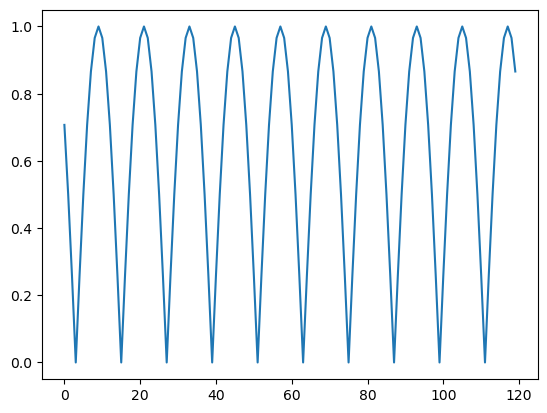

In [211]:
plt.plot(np.array(test_time_hour)[:24*5,0,0,0])

In [95]:
from datetime import datetime
timestamps = np.array(test_timef, dtype='datetime64[ns]')
hours = (timestamps.astype('datetime64[h]') - timestamps.astype('datetime64[D]')).astype(int)
months = (timestamps.astype('datetime64[M]') - timestamps.astype('datetime64[Y]')).astype(int) % 12 + 1
cos_hours = np.cos(np.deg2rad(15 * (hours.astype(int) - 10)))
cos_months = np.cos(np.deg2rad(30 * (hours.astype(int) - 3)))

In [69]:
# timestamps_list = [pd.to_datetime(ts) for sublist in test_timef.flatten() for ts in sublist]
timestamps_list = [pd.to_datetime(ts[0][0]).to_pydatetime() for ts in test_timef.flatten()]

hours = [ts.hour for ts in timestamps_list]
months = [ts.month for ts in timestamps_list]

cos_transformed_hours = np.cos(np.deg2rad(15 * (np.array(hours) - 10)))
cos_transformed_months = np.cos(np.deg2rad(30 * (np.array(months) - 3)))

transformed_timestamps = [ts.replace(hour=0, minute=0, second=0, microsecond=0) + pd.DateOffset(hours=int(h), months=int(m))
                           for ts, h, m in zip(timestamps_list, cos_transformed_hours, cos_transformed_months)]

transformed_array = np.array(transformed_timestamps).reshape(test_timef.shape)

print(transformed_array)

IndexError: invalid index to scalar variable.

In [9]:
len(cmaq_data.columns), cmaq_data.columns

(10,
 Index(['PM10', 'PM2P5', 'O3', 'NOX', 'NO', 'NO2', 'ISOPRENE', 'OLES', 'AROS',
        'ALKS'],
       dtype='object'))

In [35]:
import numpy as np
import os

# df = cmaq_data.copy()
# dates = df_concatenated.Date.values  
# stations = df_concatenated.Station_ID.values  
# cols = ['Date', 'Station_ID']
# df = df.drop(cols, axis = 1)

# Get the unique dates and stations
# unique_dates = np.unique(dates)
# unique_stations = np.unique(stations)
# print("No. of unique dates are ", len(unique_dates), "\n", "No. of Unique stations are ", len(unique_stations))

# Imputation of data, filling missing values
def add_t(arr, seq_len):
    t_len = arr.shape[0]
    assert t_len > seq_len
    arr_ts = []
    for i in range(seq_len, t_len):
        arr_t = arr[i-seq_len:i]
        arr_ts.append(arr_t)
    arr_ts = np.stack(arr_ts, axis=0)
    return arr_ts


def imputation(x):
    # num_cpus = 2  # Number of CPUs to use (adjust this according to your needs)
    # os.sched_setaffinity(0, list(range(num_cpus)))  # Set CPU affinity
    
    model_input_imputed = np.zeros((x.shape[0], x.shape[1]), dtype = float)
    # reshaping one var at a time
    for var in range(0, x.shape[1]):
        single_var = SoftImpute(verbose=False).fit_transform(x[:,var].reshape(-1,1))
        model_input_imputed[:,var] = np.squeeze(np.reshape(single_var, (x.shape[0], 1))) 
    return model_input_imputed


# Reshape the array into the desired shape
def reshaping(x, pm):
    
    # preparing the input features in the format (number_of_days/batch_size/number_of_samples, number_of_stations, number_of features)
    # Get the number of days, number of stations, and number of features
    
    num_stations = 183
    num_days = int(len(x) / (num_stations))
    if pm:
        num_features = 1
    else:
        num_features = 10
    
    reshaped_array = x.reshape(num_days, num_stations, num_features, order = 'C')
    reshaped_array = add_t(reshaped_array, 24 + 72)
    
    ###########################################################################################################################
    
    return reshaped_array



# min-max normalization

def min_max_normalization(io_data):
    io_data = (io_data - np.nanmin(io_data, axis=0)) /  (np.nanmax(io_data, axis=0) - np.nanmin(io_data, axis=0))
    return io_data


# Standard Scaler

def scaling(io_data):
    scaler = StandardScaler()
    io_data = np.nan_to_num(scaler.fit_transform(io_data))
    return io_data


def train_val_test_split(x, flag):
    
    dates = np.array(pd.to_datetime(obs_data['Date']), dtype = 'datetime64')
    train_indices = np.logical_and(dates >= np.datetime64('2016-01-01 13:00:00'), pd.to_datetime(dates) < np.datetime64('2020-01-01 13:00:00'))
    validation_indices = np.logical_and(dates >= np.datetime64('2020-01-01 13:00:00'), pd.to_datetime(dates) < np.datetime64('2021-01-01 13:00:00'))
    test_indices = dates >= np.datetime64('2021-01-01 13:00:00')
    
    
    if flag == 'Train':
        feature = x[train_indices, :]
        print(f"Shape of Training feature set is {feature.shape}")
    if flag == 'Val':
        feature = x[validation_indices, :] 
        print(f"Shape of Validation feature set is {feature.shape}")
    if flag == 'Test':
        feature = x[test_indices, :] 
        print(f"Shape of Testing feature set is {feature.shape}")
        
    return feature

In [36]:
def data_collection(x, flag):
    # imputed_array = imputation(x[:, np.newaxis])
    print("IMPUTATION IS DONE!!!")
    features = train_val_test_split(x[:, np.newaxis], flag)#(imputed array, flag)
    print("DATA SPLITING IS DONE!!!")
    reshaped_array = reshaping(features, True)
    print("RESHAPING IS DONE!!!")
    print(reshaped_array.shape)#, pm2_5.shape)
    return reshaped_array#, pm2_5


print("#######################TESTING DATA#########################")

testing_features = data_collection(obs_data['Date'].values, 'Test') 

print("###########################################################################################################################")


#######################TESTING DATA#########################
IMPUTATION IS DONE!!!
Shape of Testing feature set is (1603080, 1)
DATA SPLITING IS DONE!!!
RESHAPING IS DONE!!!
(8664, 96, 183, 1)
###########################################################################################################################


In [27]:
time_test = np.squeeze(testing_features[:, :, :, :])
time_test =  np.transpose(time_test, (0, 2, 1))
time_test.shape

(8664, 183, 96)

In [34]:
time_test[:, 0, 48]

array(['2021-01-03T13:00:00.000000000', '2021-01-03T14:00:00.000000000',
       '2021-01-03T15:00:00.000000000', ...,
       '2021-12-30T10:00:00.000000000', '2021-12-30T11:00:00.000000000',
       '2021-12-30T12:00:00.000000000'], dtype='datetime64[ns]')

In [85]:
obs_pm = testing_features[:, 24:, :, 0]

In [46]:
cmaq_pm = testing_features[:, 24:, :, 0]

In [96]:
cmaq_pm = np.transpose(cmaq_pm, (0, 2, 1))

In [87]:
labe_agat = np.squeeze(np.load('/tng4/users/rdimri/Pearson_graph_conv1d/south_korea_183/reduce_var/test_label_183.npy'))
cmaq_pm = np.transpose(cmaq_pm, (0, 2, 1))
obs_pm = np.transpose(obs_pm, (0, 2, 1))
cmaq_pm.shape, labe_agat.shape

((8664, 72, 183), (8664, 183, 72))

In [94]:
model1_predictions.shape, obs_pm.shape

((8664, 72, 183), (8664, 183, 72))

In [116]:
8760-96

8664

In [98]:
def index_of_agreement(observed, predicted):
    mean_observed = np.mean(observed)
    numerator = np.sum((predicted - observed) ** 2)
    denominator = np.sum((np.abs(predicted - mean_observed) + np.abs(observed - mean_observed)) ** 2)
    return 1 - (numerator / denominator)
stations = 183
times = 72
ioa_model1 = np.zeros(3)
model1_predictions = cmaq_pm
# for sta in range(183):
for time in range(3):
    ioa_model1[time] = np.array(index_of_agreement(obs_pm[:,:,time*24], model1_predictions[:,:,time*24]))
    
ioa_model1

array([0.66649325, 0.66654011, 0.66694164])

In [130]:
time_test[:,0,0]

array(['2021-01-02T13:00:00.000000000', '2021-01-02T14:00:00.000000000',
       '2021-01-02T15:00:00.000000000', ...,
       '2021-12-29T10:00:00.000000000', '2021-12-29T11:00:00.000000000',
       '2021-12-29T12:00:00.000000000'], dtype='datetime64[ns]')

In [125]:
o[:, 0]

array([12., 13., 14., ..., nan, nan, nan])

In [127]:
obs_pm[:, 0, 24]

array([12., 13., 14., ..., 14., 11., 12.])

In [138]:
print(IOA_Loss(torch.Tensor(obs_pm[:, :, 0]), torch.Tensor(model1_predictions[:,:,0])))
print(IOA_Loss(torch.Tensor(obs_pm[:, :, 24]), torch.Tensor(model1_predictions[:,:,24])))
print(IOA_Loss(torch.Tensor(obs_pm[:, :, 48]), torch.Tensor(model1_predictions[:,:,48])))


tensor(0.6665)
tensor(0.6665)
tensor(0.6669)


In [75]:

def IOA_Loss(o,p): 
    ioa = 1 -(torch.nansum((o-p)**2))/(torch.nansum((torch.abs(p-torch.nanmean(o))+torch.abs(o-torch.nanmean(o)))**2))
    return (ioa)

file_path = []
path_obs = '/tng7/users/dsingh/GIST_deliverables_v2/Training_&_Evaluation/Output_data/PM25_2021_QA_Eval/Day1/'
for station in range(0, len(list(nodes.items()))):
    path_og = path_obs + str(list(nodes.items())[station][0]) 
    file_path.append(glob.glob(path_og + '*.csv'))
print('Total files are ', len(file_path))

conv1d_pred1 = []
conv1d_obs1 = []
for sta in range(len(file_path)):
    conv1d_pred1.append(pd.read_csv(file_path[sta][0])['CMAQ'])
    conv1d_obs1.append(pd.read_csv(file_path[sta][0])['Obs'])
conv1d_pred1 = np.stack(conv1d_pred1, axis = 1)
conv1d_obs1 = np.stack(conv1d_obs1, axis = 1)
print(conv1d_pred1.shape, conv1d_obs1.shape)
# plt.plot(conv1d_obs1[:, 0])
o = conv1d_obs1
p = conv1d_pred1
print(IOA_Loss(torch.Tensor(o[24:8760-72, :]), torch.Tensor(p[24:8760 - 72, :])))


file_path = []
path_obs = '/tng7/users/dsingh/GIST_deliverables_v2/Training_&_Evaluation/Output_data/PM25_2021_QA_Eval/Day2/'
for station in range(0, len(list(nodes.items()))):
    path_og = path_obs + str(list(nodes.items())[station][0]) 
    file_path.append(glob.glob(path_og + '*.csv'))
print('Total files are ', len(file_path))

conv1d_pred1 = []
conv1d_obs1 = []
for sta in range(len(file_path)):
    conv1d_pred1.append(pd.read_csv(file_path[sta][0])['CMAQ'])
    conv1d_obs1.append(pd.read_csv(file_path[sta][0])['Obs'])
conv1d_pred1 = np.stack(conv1d_pred1, axis = 1)
conv1d_obs1 = np.stack(conv1d_obs1, axis = 1)
# plt.plot(conv1d_obs1[:, 0])
o = conv1d_obs1
p = conv1d_pred1
print(IOA_Loss(torch.Tensor(o[24:8760-72, :]), torch.Tensor(p[24:8760 - 72, :])))


file_path = []
path_obs = '/tng7/users/dsingh/GIST_deliverables_v2/Training_&_Evaluation/Output_data/PM25_2021_QA_Eval/Day3/'
for station in range(0, len(list(nodes.items()))):
    path_og = path_obs + str(list(nodes.items())[station][0]) 
    file_path.append(glob.glob(path_og + '*.csv'))
print('Total files are ', len(file_path))

conv1d_pred1 = []
conv1d_obs1 = []
for sta in range(len(file_path)):
    conv1d_pred1.append(pd.read_csv(file_path[sta][0])['CMAQ'])
    conv1d_obs1.append(pd.read_csv(file_path[sta][0])['Obs'])
conv1d_pred1 = np.stack(conv1d_pred1, axis = 1)
conv1d_obs1 = np.stack(conv1d_obs1, axis = 1)
# plt.plot(conv1d_obs1[:, 0])
o = conv1d_obs1
p = conv1d_pred1
print(IOA_Loss(torch.Tensor(o[24:8760-72, :]), torch.Tensor(p[24:8760 - 72, :])))

Total files are  183
(8760, 183) (8760, 183)
tensor(0.6847)
Total files are  183
tensor(0.6786)
Total files are  183
tensor(0.6746)


In [79]:
o.shape

(8760, 183)

In [31]:
np.save('/tng4/users/rdimri/Pearson_graph_conv1d/cmaq_pm25.npy', cmaq_pm)

In [26]:
def data_collection(x, flag):
    x = train_val_test_split(x, flag)``
    print(x.shape)
    print("DATA SPLITING IS DONE!!!")
    x = reshaping(x, False)
    print("RESHAPING IS DONE!!!")
    print(x.shape)
    return x

print("#######################Dates#########################")
# dates = np.array(pd.to_datetime(df_concatenated['Date']), dtype = 'datetime64')
# print(dates.shape)
test_dates = data_collection(wind_data.values, 'Test')

#######################Dates#########################
Shape of Testing feature set is (219000, 2)
(219000, 2)
DATA SPLITING IS DONE!!!
RESHAPING IS DONE!!!
(8664, 96, 25, 2)


In [36]:
wind_data = test_dates[:, :, :, :]

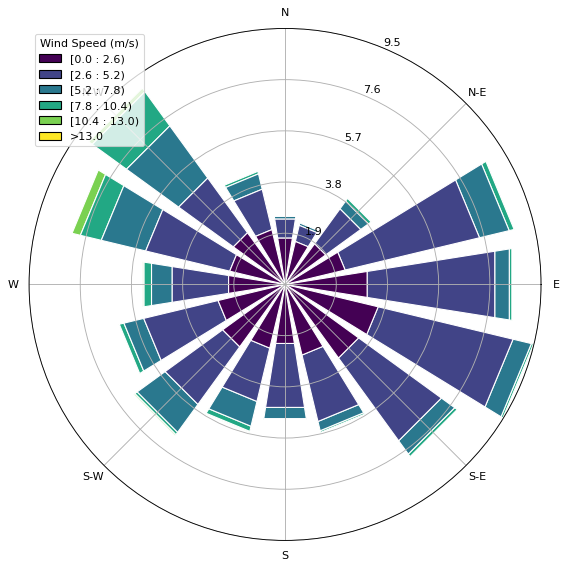

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes

wind_directions = wind_data[:, :, :, 1]
all_wind_directions = wind_directions.flatten()
wind_speeds = wind_data[:, :, :, 0].flatten()
valid_indices = ~np.isnan(all_wind_directions) & ~np.isnan(wind_speeds)
filtered_wind_directions = all_wind_directions[valid_indices]
filtered_wind_speeds = wind_speeds[valid_indices]

ax = WindroseAxes.from_ax()
ax.bar(filtered_wind_directions, filtered_wind_speeds, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
ax.legend(title='Wind Speed (m/s)', loc='upper left')

plt.show()

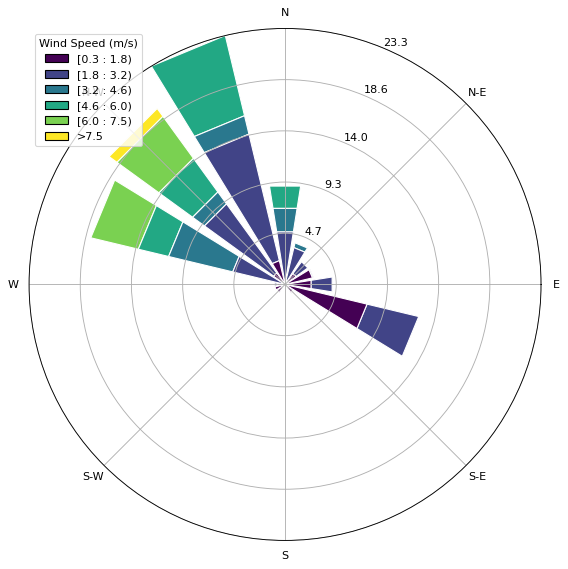

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes

wind_directions = wind_data[30, :, :, 1]
all_wind_directions = wind_directions.flatten()
wind_speeds = wind_data[30, :, :, 0].flatten()
valid_indices = ~np.isnan(all_wind_directions) & ~np.isnan(wind_speeds)
filtered_wind_directions = all_wind_directions[valid_indices]
filtered_wind_speeds = wind_speeds[valid_indices]

ax = WindroseAxes.from_ax()
ax.bar(filtered_wind_directions, filtered_wind_speeds, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
ax.legend(title='Wind Speed (m/s)', loc='upper left')

plt.show()

In [27]:
wind_data = test_dates[:, 24:, :, :]
np.save('/tng4/users/rdimri/Pearson_graph_conv1d/south_korea_183/wind_data_183.npy', wind_data)

In [18]:
test_pred_dates = test_dates[:, 24:, :, 0]
print(test_pred_dates.shape)
test_pred_dates[:,0,0]

(8664, 72, 183)


array(['2021-01-03T13:00:00.000000000', '2021-01-03T14:00:00.000000000',
       '2021-01-03T15:00:00.000000000', ...,
       '2021-12-30T10:00:00.000000000', '2021-12-30T11:00:00.000000000',
       '2021-12-30T12:00:00.000000000'], dtype='datetime64[ns]')

In [21]:
test_pred_dates[:,0,0]

array(['2021-01-02T13:00:00.000000000', '2021-01-02T14:00:00.000000000',
       '2021-01-02T15:00:00.000000000', ...,
       '2021-12-29T10:00:00.000000000', '2021-12-29T11:00:00.000000000',
       '2021-12-29T12:00:00.000000000'], dtype='datetime64[ns]')

In [17]:
def data_collection(x, flag):
    imputed_array = imputation(x)
    print("IMPUTATION IS DONE!!!")
    # pm2_5 = imputed_array[:, -1]
    # io_data = min_max_normalization(imputed_array)
    # io_data = scaling(imputed_array) # scaling(x)
    print("NORMALIZATION IS DONE!!!")
    features = train_val_test_split(imputed array, flag)
    # pm2_5 = train_val_test_split(pm2_5[:, np.newaxis], flag)
    print("DATA SPLITING IS DONE!!!")
    reshaped_array = reshaping(features, False)
    # pm2_5 = features[:,-1]
    # pm2_5 = reshaping(pm2_5, True)
    print("RESHAPING IS DONE!!!")
    print(reshaped_array.shape)#, pm2_5.shape)
    return reshaped_array#, pm2_5

# print("#######################TRAINING DATA#########################")

# training_features, training_target = data_collection(df.values, 'Train')
# np.save('/tng4/users/rdimri/Pearson_graph_conv1d/seoul/train_input_data_183_v3.npy', training_features)
# np.save('/tng4/users/rdimri/Pearson_graph_conv1d/seoul/train_target_data_183_v3.npy', training_target)

# print("###########################################################################################################################")

# print("#######################VALIDATION DATA#########################")

# val_features, val_target = data_collection(df.values, 'Val')
# np.save('/tng4/users/rdimri/Pearson_graph_conv1d/val_input_data_183.npy', val_features)
# np.save('/tng4/users/rdimri/Pearson_graph_conv1d/val_target_data_183.npy', val_target)

print("###########################################################################################################################")

print("#######################TESTING DATA#########################")

testing_features = data_collection(df.values, 'Test') #, testing_target
# np.save('/tng4/users/rdimri/Pearson_graph_conv1d/test_input_data_183_v3.npy', testing_features)
# np.save('/tng4/users/rdimri/Pearson_graph_conv1d/test_target_data_183_v3.npy', testing_target)

print("###########################################################################################################################")


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2644886586.py, line 8)

In [29]:
# training_features, training_target = data_collection(df.values, 'Train')
np.save('/tng4/users/rdimri/Pearson_graph_conv1d/seoul/train_input_data_25_v4.npy', training_features)
np.save('/tng4/users/rdimri/Pearson_graph_conv1d/seoul/train_target_data_25_v4.npy', training_target)

# print("###########################################################################################################################")

# print("#######################VALIDATION DATA#########################")

# val_features, val_target = data_collection(df.values, 'Val')
np.save('/tng4/users/rdimri/Pearson_graph_conv1d/val_input_data_25_v4.npy', val_features)
np.save('/tng4/users/rdimri/Pearson_graph_conv1d/val_target_data_25_v4.npy', val_target)

# print("###########################################################################################################################")

# print("#######################TESTING DATA#########################")

# testing_features, testing_target = data_collection(df.values, 'Test')
np.save('/tng4/users/rdimri/Pearson_graph_conv1d/test_input_data_25_v4.npy', testing_features)
np.save('/tng4/users/rdimri/Pearson_graph_conv1d/test_target_data_25_v4.npy', testing_target)

Index(['PRSFC', 'USTAR', 'WSTAR', 'PBL', 'MOLI', 'HFX', 'RADYNI', 'RSTOMI',
       'TEMPG', 'TEMP2', 'Q2', 'WSPD10', 'WDIR10', 'GLW', 'GSW', 'RGRND', 'RN',
       'RC', 'CFRAC', 'CLDT', 'CLDB', 'WBAR', 'SNOCOV', 'VEG', 'LAI', 'WR',
       'SOIM1', 'SOIM2', 'SOIT1', 'SOIT2', 'SLTYP', 'PM10', 'PM2P5', 'O3',
       'NOX', 'NO', 'NO2', 'ISOPRENE', 'OLES', 'AROS', 'ALKS', 'Obs_SO2', 'CO',
       'Obs_O3', 'Obs_NO2', 'Obs_PM10', 'PM25'],
      dtype='object')

In [1]:
import matplotlib.pyplot as plt

array1 = training_target[:, 0, 0, -1]
# array2 = val_target[:, 0, 0, -1]
# array3 = testing_target[:, 0, 0, -1]
# Assuming 'array1', 'array2', and 'array3' are the three arrays to be plotted
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot histogram and kernel density plot for array1
axes[0].hist(array1, bins=10, density=True, alpha=0.7, color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('PM2.5')
axes[0].set_title('2019 - Distribution')

# Plot histogram and kernel density plot for array2
axes[1].hist(array2, bins=10, density=True, alpha=0.7, color='green')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('PM2.5')
axes[1].set_title('2020 - Distribution')

# Plot histogram and kernel density plot for array3
axes[2].hist(array3, bins=10, density=True, alpha=0.7, color='red')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('PM2.5')
axes[2].set_title('2021 - Distribution')

# Adjust spacing between subplots and display the plot
plt.tight_layout()
plt.show()


NameError: name 'training_target' is not defined

In [16]:
print(training_features.shape, training_target.shape)

(34944, 96, 25, 47) (34944, 96, 25, 1)


In [131]:
def mycorr(x):
    mean_x = x.mean(dim = -1, keepdim = True)
    centered_x = x - mean_x
    std_x = x.std(dim = -1, keepdim = True)
    bessel_correction = x.shape[-1] - 1
    covariance = torch.matmul(centered_x, centered_x.transpose(-1, -2))
    p = covariance / bessel_correction / (torch.matmul(std_x, std_x.transpose(-1, -2)))
    return p
    
input_tensor = torch.tensor(training_features[:, 0, :, -6:])
print("Input tensor shape is ", input_tensor.shape)

correlation_matrix = mycorr(input_tensor)
print("Correlation matrix shape is  ", correlation_matrix.shape)

threshold = 0.7  # Adjust the threshold as needed
adjacency_matrix = (correlation_matrix > threshold).float()
print("Adjacency matrix shape is ", adjacency_matrix.shape)


Input tensor shape is  torch.Size([34944, 25, 6])
Correlation matrix shape is   torch.Size([34944, 25, 25])
Adjacency matrix shape is  torch.Size([34944, 25, 25])


In [179]:

coo_indices, coo_values = dense_to_sparse(batch_adjacency_matrix)
print(coo_indices.shape, coo_values.shape)
edge_src, edge_target = coo_indices
print(edge_src.shape, edge_target.shape)
# node_src = batch_data[:, edge_src]
# node_src.shape

torch.Size([2, 10584]) torch.Size([10584])
torch.Size([10584]) torch.Size([10584])


In [160]:
import torch
from torch_sparse import SparseTensor
import torch.nn.functional as F

batch_data = input_tensor[:32, :, :]
batch_adjacency_matrix = adjacency_matrix[:32, :, :]
print(batch_data.shape, batch_adjacency_matrix.shape)



in_features = 6
out_features = 6
W = torch.nn.Linear(in_features, out_features)
a = torch.nn.Linear(2 * out_features, 1)
dropout = torch.nn.Dropout(0.2)

h = W(batch_data.float())
print(h.shape)


batch_size, num_nodes, _ = batch_adjacency_matrix.shape
h_repeat = h.repeat(1, 1, num_nodes).view(batch_size, num_nodes, num_nodes, -1)
h_repeat_transpose = h_repeat.permute(0, 2, 1, 3)
attn_input = torch.cat([h_repeat, h_repeat_transpose], dim=-1)
attn_scores = a(attn_input).squeeze(dim=-1)

masked_attn_scores = attn_scores + batch_adjacency_matrix.to(attn_scores.dtype)
attn_weights = F.softmax(masked_attn_scores, dim=-1)
attn_weights = dropout(attn_weights)


torch.Size([32, 25, 6]) torch.Size([32, 25, 25])
torch.Size([32, 25, 6])


RuntimeError: stack expects each tensor to be equal size, but got [2, 321] at entry 0 and [2, 279] at entry 1

In [156]:
h_repeat.shape, h_repeat_transpose.shape, attn_input.shape, attn_scores.shape, masked_attn_scores.shape, attn_weights.shape

(torch.Size([32, 25, 25, 6]),
 torch.Size([32, 25, 25, 6]),
 torch.Size([32, 25, 25, 12]),
 torch.Size([32, 25, 25]),
 torch.Size([32, 25, 25]),
 torch.Size([32, 25, 25]))

In [157]:
attn_weights[0, :, :]

tensor([[0.1004, 0.0351, 0.1025, 0.0355, 0.0274, 0.0727, 0.0000, 0.0000, 0.0793,
         0.0000, 0.1117, 0.0289, 0.0000, 0.0257, 0.0254, 0.0821, 0.0272, 0.0322,
         0.0294, 0.0782, 0.0278, 0.0270, 0.0000, 0.0000, 0.0298],
        [0.0362, 0.0935, 0.1005, 0.0946, 0.0268, 0.0262, 0.0767, 0.0272, 0.0286,
         0.0000, 0.1096, 0.0771, 0.0317, 0.0253, 0.0249, 0.0296, 0.0000, 0.0859,
         0.0288, 0.0282, 0.0000, 0.0265, 0.0214, 0.0217, 0.0000],
        [0.0765, 0.0725, 0.0780, 0.0734, 0.0000, 0.0204, 0.0595, 0.0211, 0.0603,
         0.0000, 0.0851, 0.0599, 0.0669, 0.0196, 0.0193, 0.0625, 0.0000, 0.0667,
         0.0000, 0.0595, 0.0000, 0.0558, 0.0166, 0.0169, 0.0616],
        [0.0332, 0.0000, 0.0922, 0.0868, 0.0669, 0.0241, 0.0704, 0.0249, 0.0000,
         0.0323, 0.0370, 0.0707, 0.0791, 0.0232, 0.0228, 0.0272, 0.0245, 0.0788,
         0.0718, 0.0259, 0.0680, 0.0660, 0.0000, 0.0200, 0.0728],
        [0.0308, 0.0000, 0.0314, 0.0804, 0.0620, 0.0000, 0.0652, 0.0628, 0.0000,
       

In [112]:
x = input_tensor # pm[:, :, np.newaxis]
mean_x = x.mean(dim = -1, keepdim = True)
centered_x = x - mean_x
centered_x.shape

torch.Size([34944, 25, 6])

In [91]:
pm = input_tensor[:, :, -1]
correlation_matrix_pm = mycorr(pm[:, :, np.newaxis])
print(correlation_matrix_pm.shape)


torch.Size([34944, 25, 25])


In [114]:
data.shape

(100, 25, 6)

In [129]:
import torch

def mycorr(x):
    batch_size, num_stations, num_features = x.shape
    mean_x = x.mean(dim=0, keepdim=True)  # Calculate mean for each feature across all samples
    centered_x = x - mean_x
    std_x = x.std(dim=0, keepdim=True)  # Calculate standard deviation for each feature across all samples
    bessel_correction = batch_size - 1
    
    # Initialize an empty tensor to store correlations
    correlations = torch.zeros(batch_size, num_stations, num_stations)
    
    # Calculate correlations for each feature
    for feature_idx in range(num_features):
        feature_data = centered_x[:, :, feature_idx]
        covariance = torch.matmul(feature_data.transpose(0, 1), feature_data) / bessel_correction
        correlation = covariance / (std_x[0, :, feature_idx] * std_x[0, :, feature_idx].unsqueeze(1))
        correlations[:, :, :] += correlation
    
    return correlations / num_features

# Example usage:
import numpy as np
x = np.random.rand(100, 25, 6)
x = torch.tensor(x, dtype=torch.float32)
correlation_matrix = mycorr(pm[:, :, np.newaxis])
print(correlation_matrix.shape)  # Should be [100, 25, 25]


torch.Size([34944, 25, 25])


<Axes: >

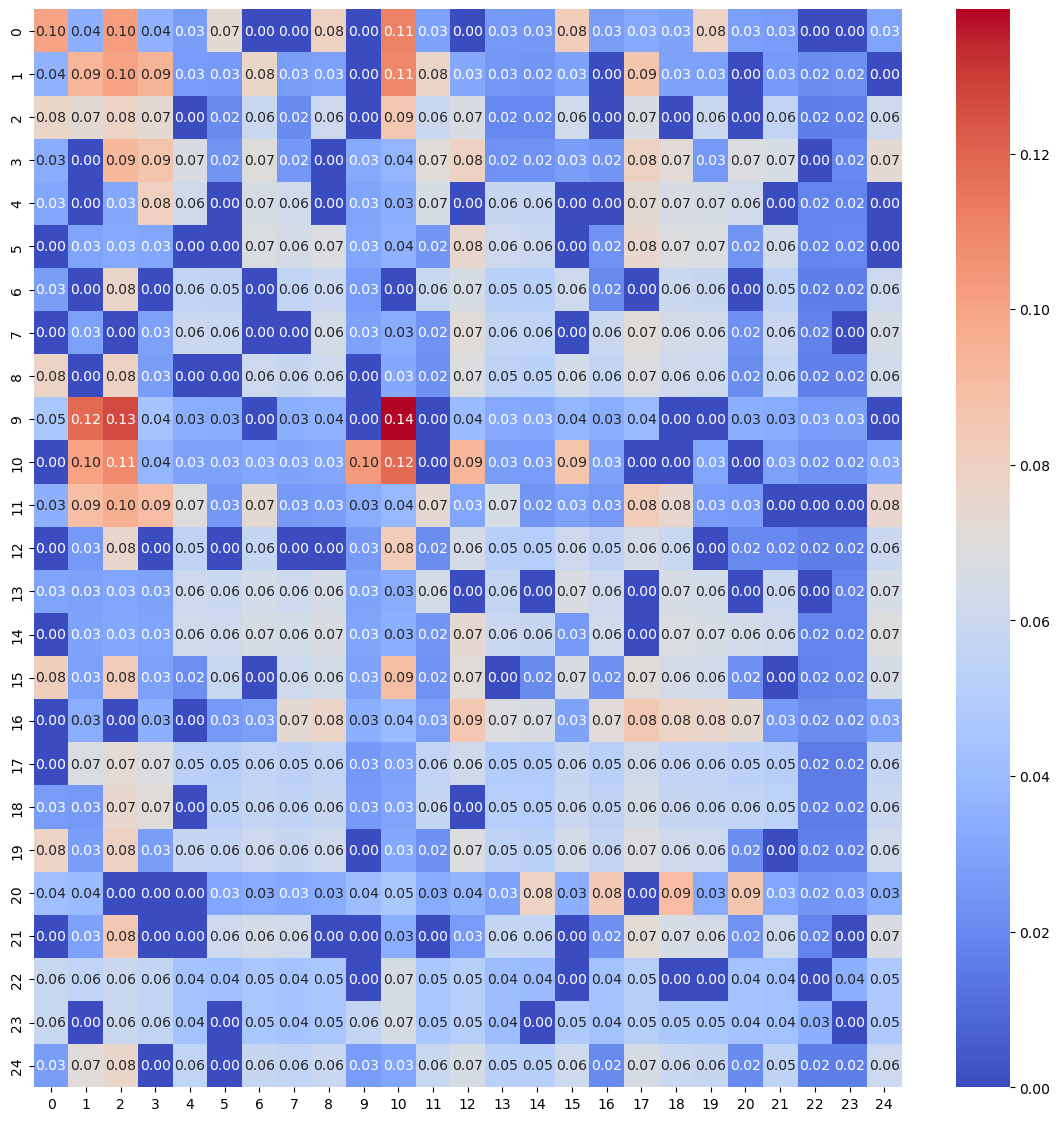

In [159]:
a = adjacency_matrix
plt.figure(figsize=(14, 14))
sns.heatmap(attn_weights[0, :, :].detach().numpy(), annot=True, cmap='coolwarm', fmt='.2f')

<Axes: >

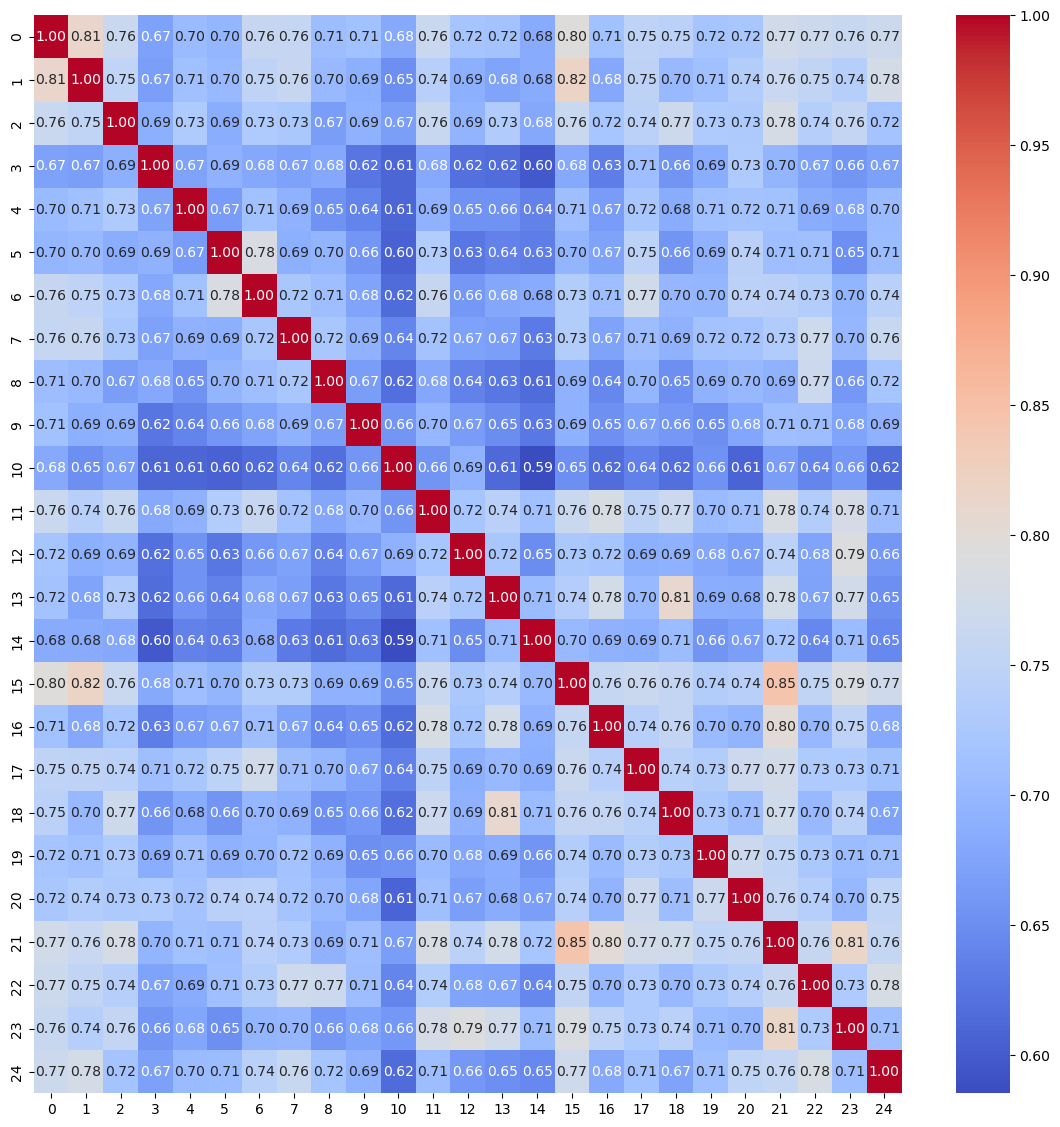

In [127]:
a = correlation_matrix
plt.figure(figsize=(14, 14))
sns.heatmap(a[5], annot=True, cmap='coolwarm', fmt='.2f')

<Axes: >

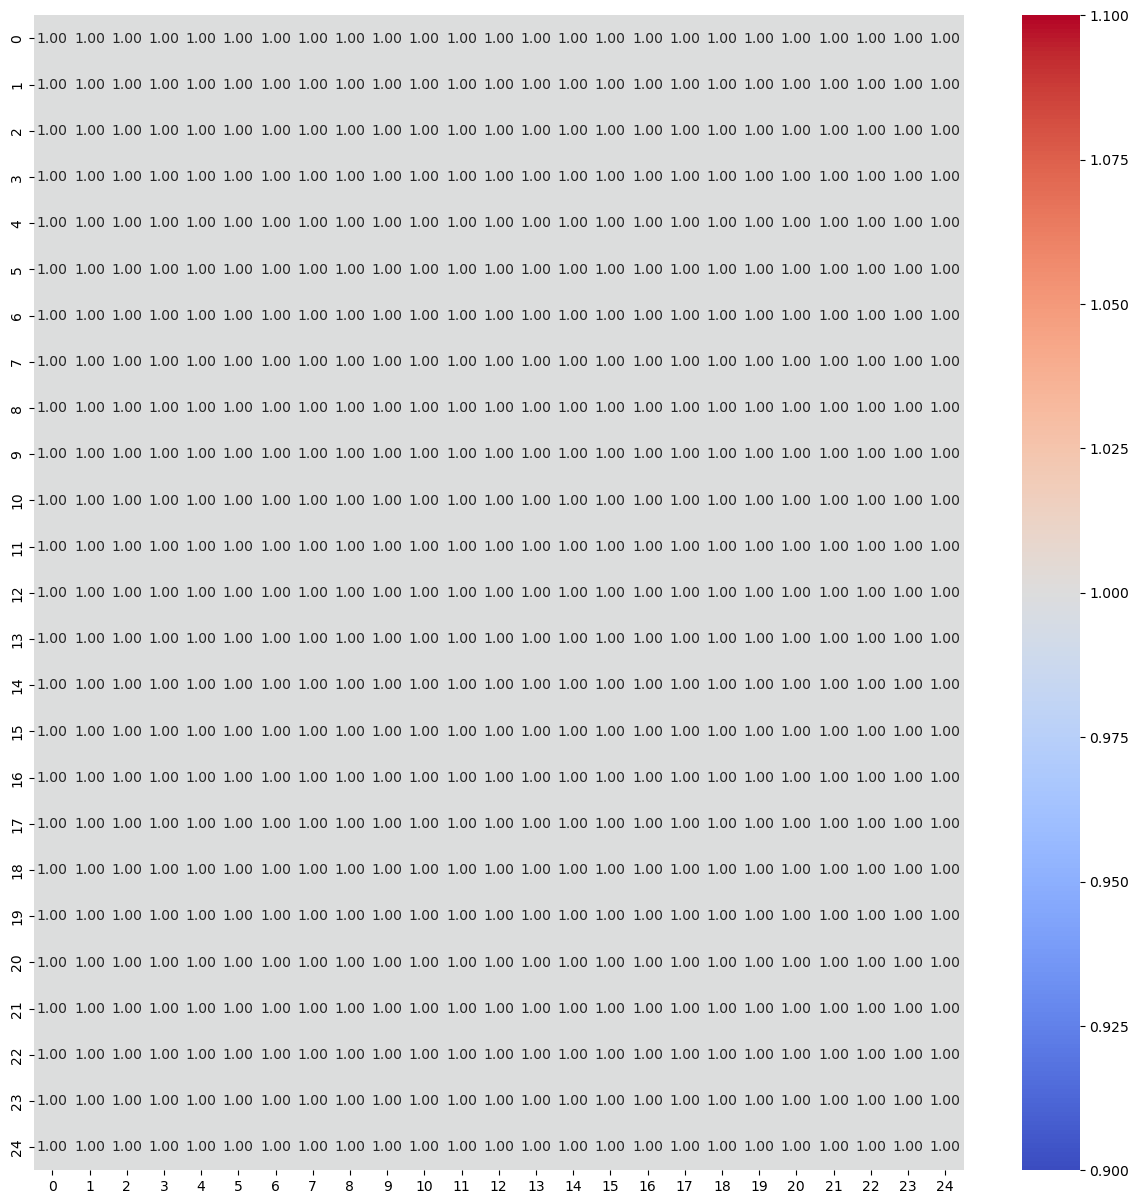

In [58]:
import seaborn as sns
a = adjacency_matrices[0]
plt.figure(figsize=(15, 15))
sns.heatmap(a, annot=True, cmap='coolwarm', fmt='.2f')

In [106]:
from torch_geometric.utils import dense_to_sparse, to_dense_adj
edge_index, _ = dense_to_sparse(torch.tensor(adjacency_matrix)[0, 0, :, :])
print(edge_index.shape)

torch.Size([2, 321])


/tmp/ipykernel_2351764/2974159486.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index, _ = dense_to_sparse(torch.tensor(adjacency_matrix)[0, 0, :, :])


In [110]:
x = torch.tensor(training_features[:, 0, :, :])
print(x.shape)

torch.Size([34944, 25, 47])


In [111]:
edge_src, edge_target = edge_index
node_src = x[:, edge_src]
node_target = x[:, edge_target]
print(edge_src.shape, edge_target.shape)
print(node_src.shape, node_target.shape)

torch.Size([321]) torch.Size([321])
torch.Size([34944, 321, 47]) torch.Size([34944, 321, 47])


In [121]:
nodes = OrderedDict()
folder_path = '/tng4/users/rdimri/korea_srtm/station_wise/'
with open('/tng4/users/rdimri/old_home/' + 'korea_urban_site.csv', 'r') as f:# _201912_distance.csv', 'r') as f:
    for line in f:
        index_long, index_lat, index = line.rstrip('\n').split(',') #index, longitude, latitude, index_long, index_lat, dist_grid = line.rstrip('\n').split(',')
        index = int(index)
        file_name = 'staion_' + str(index) + '.nc'
        file_path = str(folder_path + file_name)
        assert os.path.isfile(file_path)
        latitude = xr.open_dataset(file_path).lat
        longitude = xr.open_dataset(file_path).lon
        longitude, latitude = float(longitude), float(latitude)
        nodes.update({index: {'lon': longitude, 'lat': latitude}})

In [134]:
seoul = list(nodes.items())[:25]

In [138]:
i[1]['lon']

126.97

In [152]:
adjacency_matrix.shape,

torch.Size([34944, 24, 25, 25])

In [151]:
from scipy.spatial import distance
coords = []
lonlat = {}
for i in seoul:
    coords.append([i[1]['lon'], i[1]['lat']])
dist = distance.cdist(coords, coords, 'euclidean')
print(dist.shape)
adj = 
dist = torch.tensor(dist) * 111
dist = dist * adjacency_matrix
edge_index, dist = dense_to_sparse(torch.tensor(dist))

(25, 25)


/tmp/ipykernel_2351764/3175019111.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index, dist = dense_to_sparse(torch.tensor(dist))


ValueError: Dense adjacency matrix 'adj' must be 2- or 3-dimensional (got 4 dimensions)

In [114]:
src_wind = node_src[:, :, 11:13]
src_wind_speed = src_wind[:, :, 0]
src_wind_direc = src_wind[:, :, 1]
edge_attr_ = self.edge_attr[None, :, :].repeat(node_src.size(0), 1, 1)
city_dist = self.edge_attr_[:, :, 0]
city_direc = self.edge_attr_[:, :, 1]
theta = torch.abs(city_direc - src_wind_direc)
edge_weight = torch.relu(3 * src_wind_speed * torch.cos(theta) / city_dist)
edge_weight = edge_weight.to(self.device)

tensor([ 0,  2,  5,  7,  8, 10, 12, 15, 19,  1,  2,  3,  6,  9, 10, 11, 17, 24,
         0,  1,  2,  3,  6,  8,  9, 10, 11, 12, 15, 17, 18, 19, 21, 24,  1,  2,
         3,  4,  6, 11, 12, 17, 18, 20, 21, 24,  3,  4,  6,  7,  8, 11, 12, 13,
        14, 16, 17, 18, 19, 20, 24,  0,  5,  6,  7,  8, 12, 13, 14, 15, 17, 18,
        19, 21, 24,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 17, 18,
        19, 21, 24,  0,  4,  5,  6,  7,  8, 12, 13, 14, 15, 16, 17, 18, 19, 21,
        24,  0,  2,  4,  5,  6,  7,  8, 12, 13, 14, 15, 16, 17, 18, 19, 21, 24,
         1,  2,  9, 10,  0,  1,  2,  9, 10, 12, 15,  1,  2,  3,  4,  6, 11, 13,
        17, 18, 21, 24,  0,  2,  3,  4,  5,  6,  7,  8, 10, 12, 13, 14, 15, 16,
        17, 18, 19, 24,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        21, 24,  4,  5,  6,  7,  8, 12, 13, 14, 16, 17, 18, 19, 20, 21, 24,  0,
         2,  5,  6,  7,  8, 10, 12, 13, 15, 17, 18, 19, 21, 24,  4,  7,  8, 12,
        13, 14, 16, 17, 18, 19, 20,  1, 

In [113]:
edge_src

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 17, 

<Axes: >

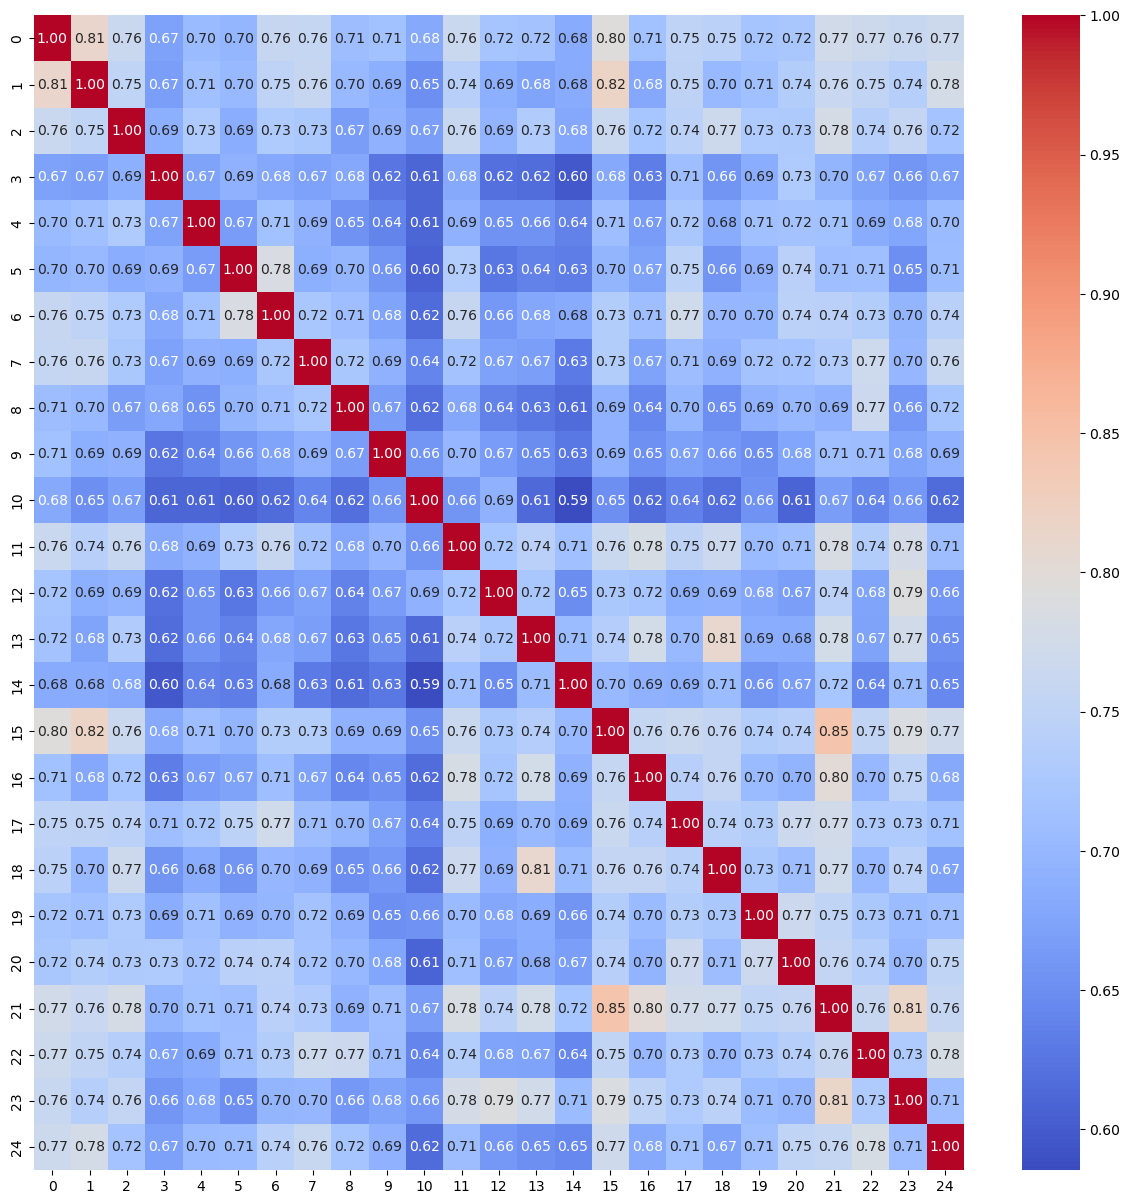

In [32]:
import seaborn as sns
a = correlations
plt.figure(figsize=(15, 15))
sns.heatmap(a/6, annot=True, cmap='coolwarm', fmt='.2f')

Adjacency matrix shape is  torch.Size([34944, 24, 25, 25])


In [91]:
e.shape

torch.Size([34944, 25, 25])

<Axes: >

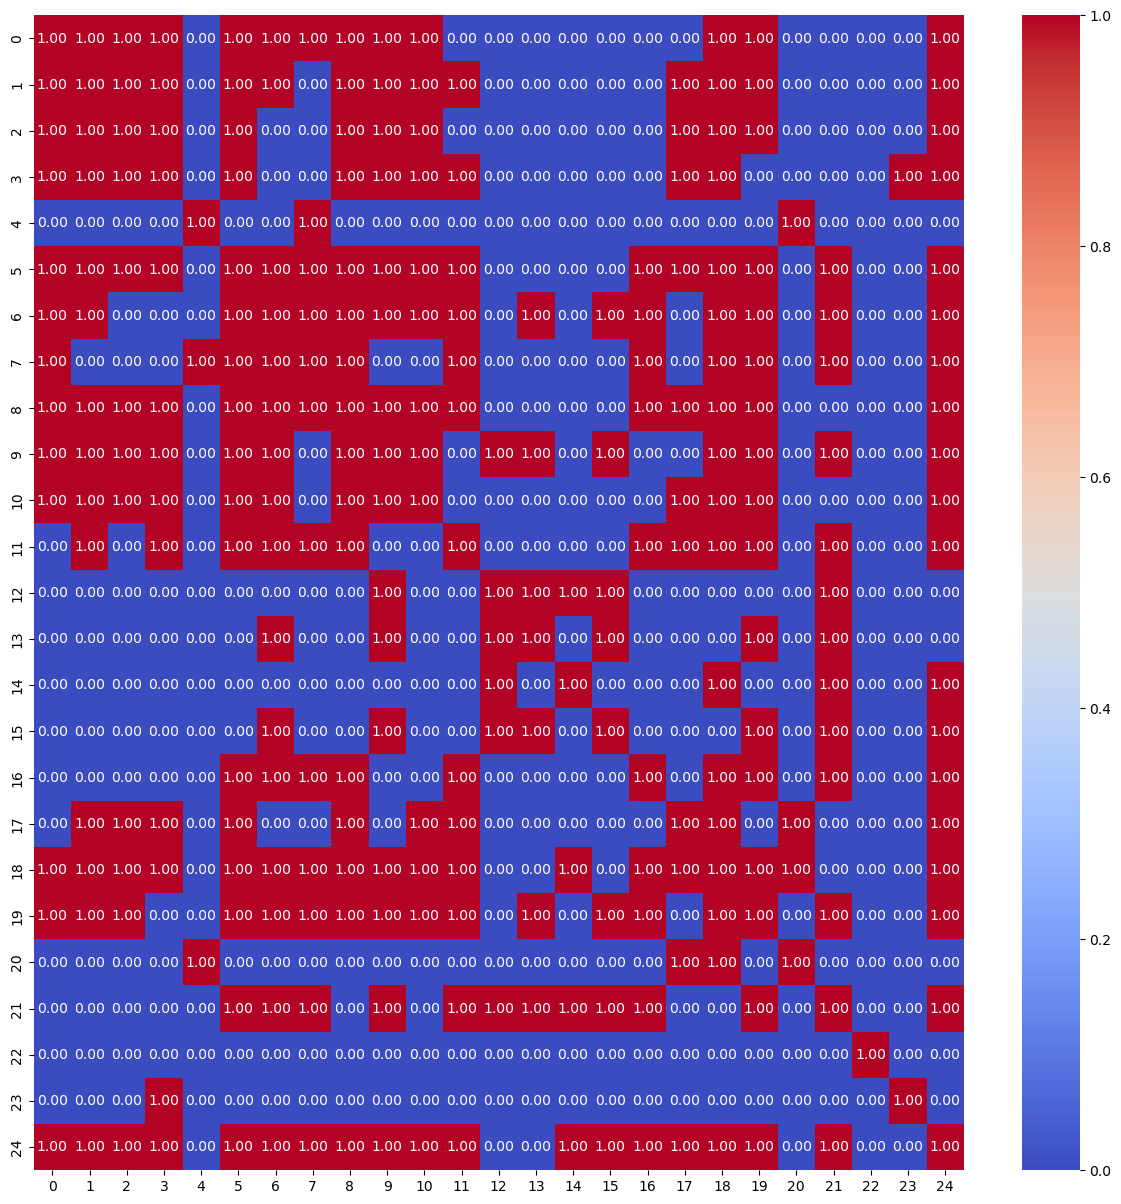

In [79]:
a = adjacency_matrix
plt.figure(figsize=(15, 15))
sns.heatmap(a[0, 1, :, :], annot=True, cmap='coolwarm', fmt='.2f')

<Axes: >

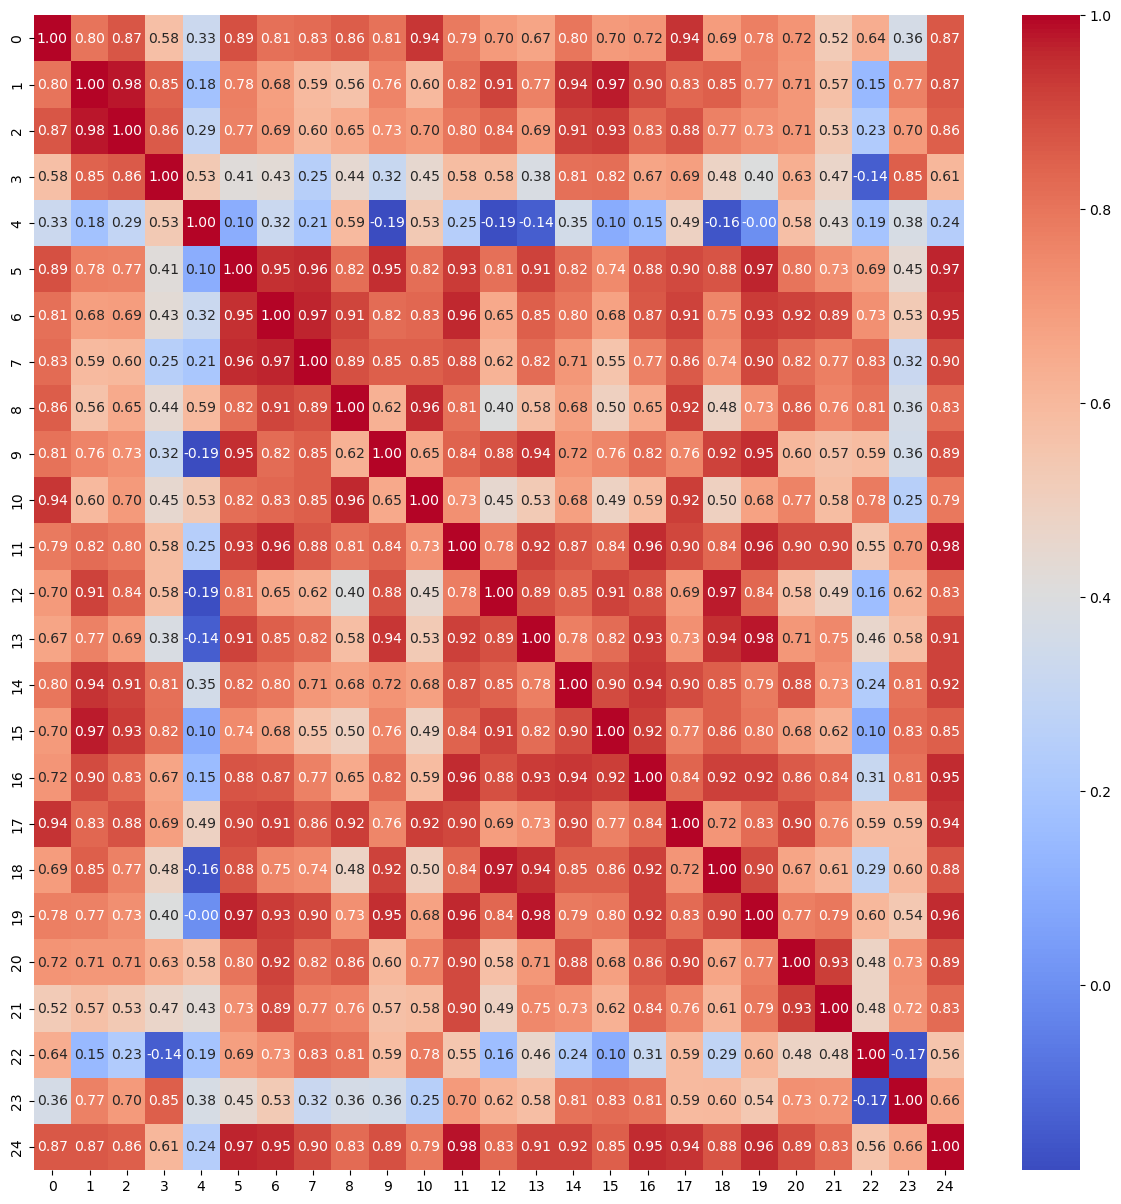

In [63]:
a = correlation_matrix
plt.figure(figsize=(15, 15))
sns.heatmap(a[0, 23, :, :], annot=True, cmap='coolwarm', fmt='.2f')

In [31]:
print(len(lag_results))
print(np.)

24


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [64]:
a = np.zeros((24, 24))
for time1 in range(24):
    for time2 in range(24):
        a[time1, time2] = np.corrcoef(data[:, time1, 0], data[:, time2, 21])[0, 1]

<Axes: >

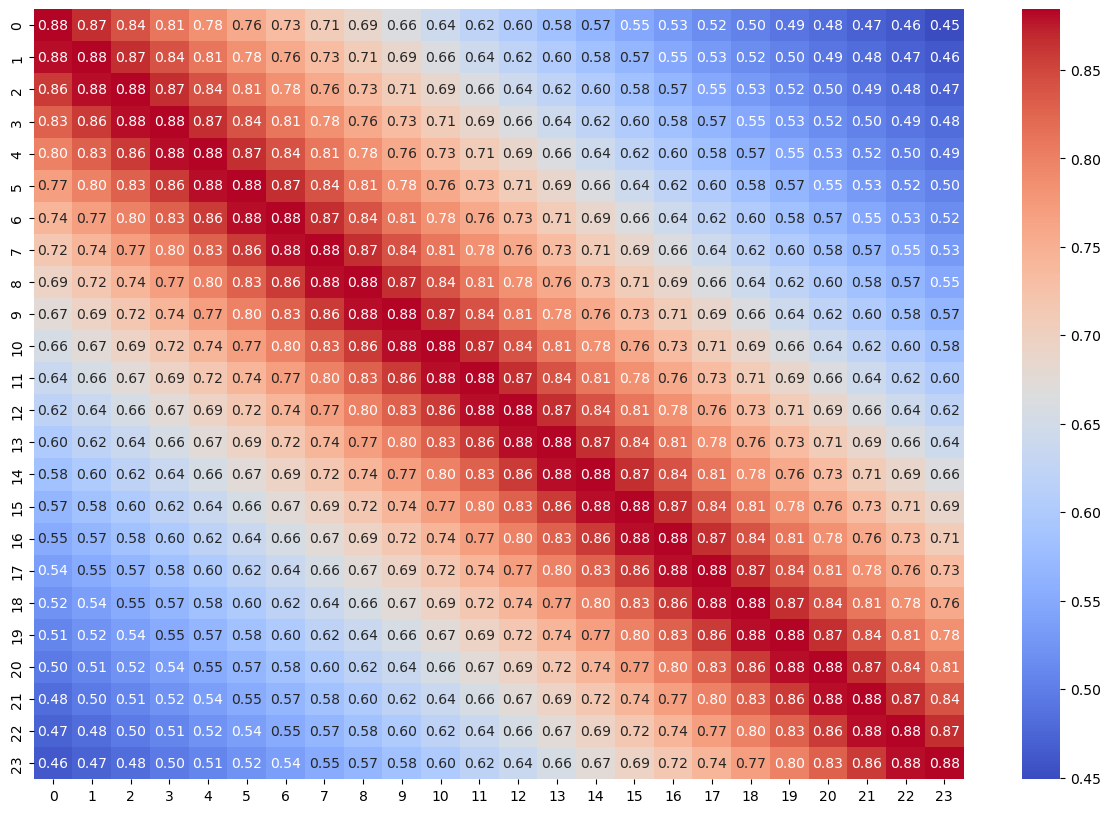

In [65]:
plt.figure(figsize=(15, 10))
sns.heatmap(a, annot=True, cmap='coolwarm', fmt='.2f')